# SPARK SQL (CLOUDS Fall 2018)

In this notebook, we will learn how to use the DataFrame API and SparkSQL to perform simple data analytics tasks.

# Goals
The main goals of this notebook are the following:
1. Understand the advantages and disadvantages of using DataFrame over RDD
2. Analyze the airline data with the DataFrame API and SparkSQL

# Steps

- First, in section 1, we will go through a short introduction about the DataFrame API with a small example to see how can we use it and how it compares to the low-level RDD abstraction.
- In section 2, we delve into the details of the use case of this notebook including: providing the context, introducing the data
- In section 3, we perform data exploration and analysis

# 1. RDD and DataFrame APIs

In our previous notebooks, we have worked with RDDs (Resilient Distributed Dataset), the basic abstraction in Spark. The main reason is due to the task at hand: we have been invovled in the design of distributed algorithms.

In this laboratory session, we study (or revisit) the DataFrame API - an immutable distributed collection of data.
DataFrames allow developers to impose a **structure** on a distributed collection of data, allowing higher-level abstraction; in addition, DataFrames provide a domain specific language (DSL) API to manipulate distributed, structured data. Ultimately, the goal is to make Spark accessible to a wider audience, beyond researchers and specialized data engineers.

Let's take a small example to see the difference between RDDs and DataFrames. The two cells below contain short code snippets that perform the same task: count the frequency of words in a document, then sort the result in descending order. The first snippet is the same you have been working on in the very [first notebook](https://github.com/EURECOM-CLOUDS-COURSE/Introduction/blob/master/introduction-lab.ipynb) of the CLOUDS course.
The second code snippet uses the DataFrame API.

<div class="alert alert-block alert-info">

<strong>Question 1.</strong> 

Run both approaches (RDD and DataFrame) detailed below, compare their runtime, and discuss. Is the DataFrame API approach faster? Can you explain why?

</div>

In [1]:
import time
time_start = time.time()
words = (
            # read the text file
            sc.textFile("/datasets/gutenberg/gutenberg_small.txt").repartition(16)
            
            # construct words from lines
            .flatMap(lambda line: line.split())
            
            # map each word to (word, 1)
            .map(lambda x: (x, 1))
    
            # reduce by key: accumulate sum the freq of the same word
            .reduceByKey(lambda freq1, freq2: freq1 + freq2)
            
            # swap (word, freq) to (freq, word)
            .map(lambda x: (x[1], x[0]))
    
            # sort result by key DESC
            .sortByKey(False)
         )
print("Runtime: %.2f sec" % (time.time() - time_start))
print(words.take(5))

Runtime: 137.22 sec
[(29556020, 'the'), (18043957, 'of'), (14914748, 'and'), (12892052, 'to'), (9779124, 'a')]


In [2]:
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql.functions import explode, split, desc
import time
sqlContext = SQLContext(sc)
time_start = time.time()


# read the text file
df = sqlContext.read.text("/datasets/gutenberg/gutenberg_small.txt")

# show 3 samples
# df.show(3)

result = (
    # split into words
    df.select(explode(split(df.value, "\s+|\t+")).alias('word'))
    
    # group by each word
    .groupBy(['word'])
    
    # count the freq
    .count()
    
    # sort the result
    .orderBy(desc("count"))
)

result.show(5)
print("Runtime: %.2f sec" % (time.time() - time_start))

+----+--------+
|word|   count|
+----+--------+
| the|29556020|
|  of|18043957|
|    |16611988|
| and|14914748|
|  to|12892052|
+----+--------+
only showing top 5 rows

Runtime: 97.08 sec


Both of the above pieces of code work on the same task of word count and displaying the top 5 words, but the approach of using the DataFrame API (97.08 sec) achieved the task faster than the approach of using RDDs (137.22 sec).<br>
This is because the SparkSQL and its utilization of the DataFrame API possesses features that enhance the efficiency and optimize the execution of the required operations of data. In SparkSQL, the <b>Catalyst Optimizer</b>, which is a component of SparkSQL, works on the optimization of the query implementation and processing. It optimizes the <b>logical plan</b> of the desired query by implementing several optimization rules on the <b>query tree</b> and also chooses the best <b>physical plan</b> of the query based on the cost model as well as code generation with <b>quasiquoutes</b>. So it has rule-based and cost-based optimization capabilities which is a big boost over the RDD approach implementation.<br>

# 2. Analysis of flight data using the DataFrame API and SparkSQL

## Use case

In this notebook, we play the role of a data scientist working in the travel industry, specifically on air transportation of passengers. We want to explore the data collected by the Department of Transportation (DoT) to understand passengers' behavior, as well as the properties of all flights, across several airline companies.

The dataset provided by the DoT has 29 features, that can be either categorical or numerical. For example, the ```src_airport``` (source airport) is categorical: there exist no comparison operator between airport names. We can not say "SGN is bigger than NCE". The ```departure_time``` feature is numerical, for which a comparison operator exists. For instance, "flight departing before 6PM" can be express by "departure_time < 1800".

In this use case, most features are numerical, except carrier, flight_number, cancelled, cancelation_code and diverted. 
The data contains a header, that is useless when analyzing the data: it serves the purpose of an "embedded schema", to help data scientist figure out what information is available. Note that there are some features with missing values in some lines of the dataset. The missing values are marked by "NA". These values can cause problems when processing the data and can lead to unexpected results. Therefore, we need to remove the header and replace all "NA" values by empty values, such as they can be interpreted as null values.

## DataFrame
As we have seen already, there are multiple ways to manipulate data:

- Using the RDD abstraction

- Using the DataFrame abstraction. 

A DataFrame is a distributed collection of data organized into named columns. It is based on the data frame concept in R language or in Pandas for Python. In some sense, it is similar to a table in a relational database: each item is a list of values (the columns). Also, the value in each row of each column can be accessed by the column's name.

To use DataFrames, the data should be clean (no invalid values). That means we cannot create DataFrame directly from the "RAW" data. Instead, we will first create an RDD from RAW data, produce a new, clean RDD, then transform it to a DataFrame and work on it. The RDD `cleaned_data` is an `RDD[String]`. We need to transform it to `RDD[(TypeOfColumn1, TypeOfColumn2, ..., TypeOfColumn29)]` then call a function to create a DataFrame from the new RDD. Please note that, package `com.databricks.spark.csv` can really help us to load the data efficiently without concerns about parsing, conversions, etc... However, the CSV package can have some problems when loading not well-formatted data or the data that has many kinds of missing values. The guidelines defined this notebook are a general way to help you work with any data.


DataFrames can be constructed from a wide array of sources such as: structured data files, tables in Hive, external databases, or existing RDDs.

During the labs in this course, we will mainly work with CSV data files. So, in the next sections, we only focus on constructing dataframes from structured data files directly and from existing RDD.

### Constructing a DataFrame directly from structured data file

To construct DataFrame from a structured file directly, the file type must be supported. Currently, Spark supports csv, json, avro and many more. Among these types, the csv type is one of the most popular in data analytics. A DataFrame is constructed from csv files by using the package spark-csv from Databricks.


In [3]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

df = sqlContext.read.load('/datasets/airline/1994.csv', 
    format='com.databricks.spark.csv', 
    header='true', 
    inferSchema='true',
    nullValue='NA'
)

Using the function load parametrized with `com.databricks.spark.csv`, we ask the SqlContext to use the parser from the DataBricks package. Additionally, we can specify whether the file has a header, or ask the parser to guess the data type of columns automatically. The parsed data types is viewed using the function printSchema.

In [4]:
# print(df.dtypes)
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |

As you can see, the automatically inferred data types are **not** as expected. For example, we expect that `CRSDepTime` to be of interger type. The type and the name of each column can be modified using function ```withColumn``` and ```withColumnRename``` respectively. Additionally, we can also compute and print basic descriptive statistics of numerical columns via the function ```describe``` (similar to Pandas).

In [5]:
df = (df
          # change type of column CRSDepTime by casting its values to interger type
          .withColumn('CRSDepTime', df.CRSDepTime.cast('int'))

          # rename the column
          .withColumnRenamed('CRSDepTime', 'scheduled_departure_time')
    )

# print schema of the current data
df.printSchema()

# run jobs to calculate basic statistic information and show it
df.describe().show()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nulla

### Constructing a DataFrame from an existing RDD

Another way to construct a DataFrame is using data from an existing RDD. The main advantage of this approach is that it does not need a third party library. However, with this method, we have to remove the header ourself and provide a clear schema.



In [1]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import explode, split, desc, col, udf, round, when, stddev_pop
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
import seaborn as sns

sqlContext = SQLContext(sc)

data = sc.textFile('/datasets/airline/1994.csv')

# extract the header
header = data.first()

# replace invalid data with NULL and remove header
cleaned_data = (
        data
    
        # filter out the header
        .filter(lambda line: line != header)
    
         # replace the 'missing data' by empty value
        .map(lambda line: ','.join(list(map(lambda x: x if x != 'NA' else '',line.split(',')))))
    )

airline_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("year",                     IntegerType(), True), \
    StructField("month",                    IntegerType(), True), \
    StructField("day_of_month",             IntegerType(), True), \
    StructField("day_of_week",              IntegerType(), True), \
    StructField("departure_time",           IntegerType(), True), \
    StructField("scheduled_departure_time", IntegerType(), True), \
    StructField("arrival_time",             IntegerType(), True), \
    StructField("scheduled_arrival_time",   IntegerType(), True), \
    StructField("carrier",                  StringType(),  True), \
    StructField("flight_number",            StringType(),  True), \
    StructField("tail_number",              StringType(),  True), \
    StructField("actual_elapsed_time",      IntegerType(), True), \
    StructField("scheduled_elapsed_time",   IntegerType(), True), \
    StructField("air_time",                 IntegerType(), True), \
    StructField("arrival_delay",            IntegerType(), True), \
    StructField("departure_delay",          IntegerType(), True), \
    StructField("src_airport",              StringType(),  True), \
    StructField("dest_airport",             StringType(),  True), \
    StructField("distance",                 IntegerType(), True), \
    StructField("taxi_in_time",             IntegerType(), True), \
    StructField("taxi_out_time",            IntegerType(), True), \
    StructField("cancelled",                StringType(),  True), \
    StructField("cancellation_code",        StringType(),  True), \
    StructField("diverted",                 StringType(),  True), \
    StructField("carrier_delay",            IntegerType(), True), \
    StructField("weather_delay",            IntegerType(), True), \
    StructField("nas_delay",                IntegerType(), True), \
    StructField("security_delay",           IntegerType(), True), \
    StructField("late_aircraft_delay",      IntegerType(), True)\
])

In [2]:
# convert each line into a tuple of features (columns) with the corresponding data type
cleaned_data_to_columns = (
    cleaned_data.map(lambda l: l.split(","))
    .map(lambda cols: 
         (
            int(cols[0])  if cols[ 0] else None,
            int(cols[1])  if cols[ 1] else None,
            int(cols[2])  if cols[ 2] else None,
            int(cols[3])  if cols[ 3] else None,
            int(cols[4])  if cols[ 4] else None,
            int(cols[5])  if cols[ 5] else None,
            int(cols[6])  if cols[ 6] else None,
            int(cols[7])  if cols[ 7] else None,
            cols[8]       if cols[ 8] else None,
            cols[9]       if cols[ 9] else None,
            cols[10]      if cols[10] else None,
            int(cols[11]) if cols[11] else None,
            int(cols[12]) if cols[12] else None,
            int(cols[13]) if cols[13] else None,
            int(cols[14]) if cols[14] else None,
            int(cols[15]) if cols[15] else None,
            cols[16]      if cols[16] else None,
            cols[17]      if cols[17] else None,
            int(cols[18]) if cols[18] else None,
            int(cols[19]) if cols[19] else None,
            int(cols[20]) if cols[20] else None,
            cols[21]      if cols[21] else None,
            cols[22]      if cols[22] else None,
            cols[23]      if cols[23] else None,
            int(cols[24]) if cols[24] else None,
            int(cols[25]) if cols[25] else None,
            int(cols[26]) if cols[26] else None,
            int(cols[27]) if cols[27] else None,
            int(cols[28]) if cols[28] else None
         ))             
)
    
# create dataframe
df = sqlContext.createDataFrame(cleaned_data_to_columns, airline_data_schema)\
    .select(['year', 'month', 'day_of_month', 'day_of_week',
            'scheduled_departure_time','scheduled_arrival_time',
            'arrival_delay', 'distance', 
            'src_airport', 'dest_airport', 'carrier'])\
    .cache()

### Examples

Using the contructed DataFrame, we can answer some simple questions:

<ul>
<li>How many night flights do we have in our data?</li>
<li>How many night flights per unique carrier?</li>
</ul>

<strong>NOTE:</strong> We define "night" to start at 6pm.

In [8]:
df[df.scheduled_departure_time > 1800].count()

1078203

In [9]:
df[df.scheduled_departure_time > 1800].groupBy(df.carrier).count().orderBy('count', ascending=0).collect()

[Row(carrier='DL', count=208224),
 Row(carrier='US', count=170397),
 Row(carrier='AA', count=142832),
 Row(carrier='WN', count=124024),
 Row(carrier='UA', count=113640),
 Row(carrier='NW', count=100453),
 Row(carrier='CO', count=94501),
 Row(carrier='TW', count=54771),
 Row(carrier='HP', count=44351),
 Row(carrier='AS', count=25010)]

# 3. Data exploration
Next, we will go over a series of simple queries on our data, to perform exploration and compute statistics using the DataFrame API and SparkSQL. These queries directly map to the questions you need to answer. 

**NOTE:** finding the right question to ask is difficult! Don't be afraid to complement the questions below, with your own questions that, in your opinion, are valuable ways to inspect data. This can give you extra points!

- Basic queries:
  - How many unique origin airports?
  - How many unique destination airports?
  - How many carriers?
  - How many flights that have a scheduled departure time later than 18h00?


- Statistics on flight volume: this kind of statistics are helpful to reason about delays. Indeed, it is plausible to assume that "*the more flights in an airport, the higher the probability of delay*".
  - How many flights in each month of the year?
  - Is there any relationship between the number of flights and the days of week?
  - How many flights in different days of months and in different hours of days?
  - Which are the top 20 busiest airports (this depends on inbound and outbound traffic)?
  - Which are the top 20 busiest carriers?


- Statistics on the fraction of delayed flights
  - What is the percentage of delayed flights (over total flights) for different hours of the day?
  - Which hours of the day are characterized by the longest flight delay?
  - What are the fluctuation of the percentage of delayed flights over different time granularities?
  - What is the percentage of delayed flights which depart from one of the top 20 busiest airports?
  - What is the percentage of delayed flights which belong to one of the top 20 busiest carriers?

## Question 2: Basic queries

### Question 2.1
<div class="alert alert-info">

How many origin airports? How many destination airports? Discuss the results, indicating any discrepancies or strange facts about the data.

</div>

In [10]:
print("The number of origin airports is: "
      ,df.select("src_airport")
      .distinct()
      .count())

The number of origin airports is:  224


In [11]:
print("The number of origin airports is: "
      ,df.select("dest_airport")
      .distinct()
      .count())

The number of origin airports is:  225


According to the results given by the two queries above, there is something quite strange about them and that is that the number of origin airports (224) is less than the number of destination airports (225) in our data.

### Question 2.2

<div class="alert alert-info">
How many unique carriers are present in the data?
</div>

In [12]:
print("The number of carriers in the data is: "
      ,df.select("carrier")
      .distinct()
      .count())

The number of carriers in the data is:  10


### Question 2.3

<div class="alert alert-info">
<ul>
<li>How many night flights (that is, flights departing later than 6pm or earlier than 6am)?</li>
<li>What is the percentage of night flights over the total volume of flights</li>
</ul>
<br>
<strong>NOTE:</strong> Here we're using a more refined definition of what is a night flight, than in our earlier examples.

</div>

In [13]:
print("The number of night flights in the data is: "
      ,df[(df.scheduled_departure_time>1800) | (df.scheduled_departure_time<600)]
      .count())

The number of night flights in the data is:  1121918


In [14]:
 print("The percentage of night flights is:"
       ,df[(df.scheduled_departure_time > 1800) | (df.scheduled_departure_time < 600)]
       .count()*100/df.count(), "%.")

The percentage of night flights is: 21.658447952605844 %.


## Question 3: Flight volume statistics

### Question 3.1: 

<div class="alert alert-info">
How many flights in each month of the year? Plot the changes over months by a line chart and comment the figure.

<br>
From the result, we can learn the dynamics of flight volume over months. For example, if we only consider flights in 1994 (to start, it's always better to focus on smaller amount of data), we can discuss about which months are most likely to have flights experiencing delays.
</div>


    Month   count
0       1  423861
1       2  386954
2       3  435516
3       4  420995
4       5  436432
5       6  426490
6       7  443736
7       8  451086
8       9  430861
9      10  449369
10     11  428227
11     12  446521


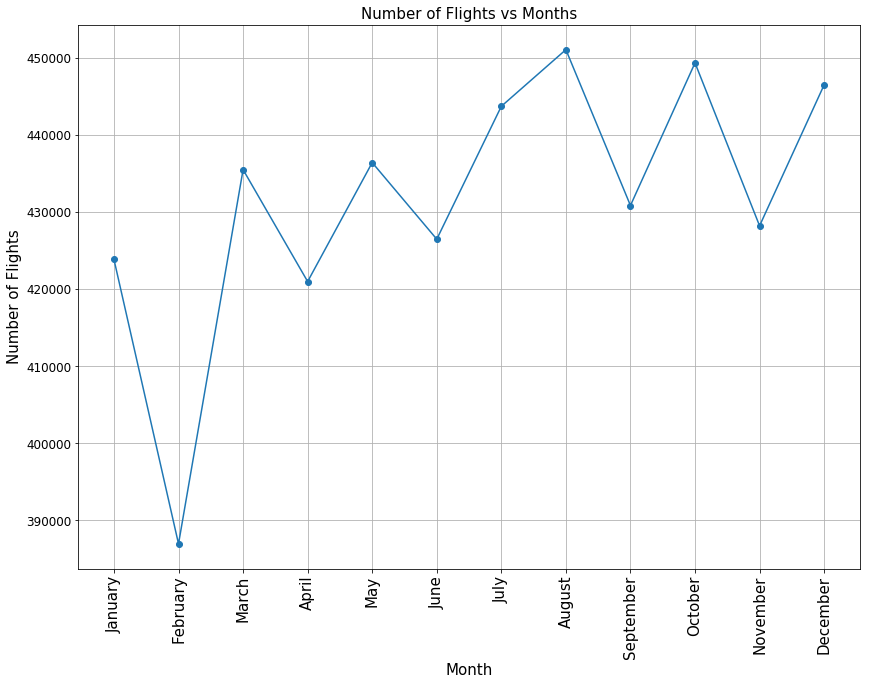

In [15]:
# group the months and aggregate over the number of flights
# sort by month
# convert the dataframe to a pandas dataframe

flightsPerMonth = df.groupBy('Month')\
.count()\
.orderBy("Month")\
.toPandas()

# display the the number of flights for every month
print(flightsPerMonth)

# plot the number of flights per month
plt.figure(figsize = (14,10))
plt.grid(True)
plt.title("Number of Flights vs Months",fontsize = 15)
plt.xlabel("Month",fontsize = 15)
plt.ylabel("Number of Flights",fontsize = 15)
plt.xticks(np.arange(1,13),['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],fontsize=15,rotation='vertical')
plt.yticks(fontsize=12)
plt.plot(flightsPerMonth["Month"],
         flightsPerMonth["count"]
         ,'-o'
        )

According to the line chart, we mainly witness peaks (up to 449K)in the number of flights in the second half of the year, especially in July, August, October, and December. <b>These four months can be expected to most likely experience flight delays due to the increased number of flights.</b><br>
For July (443736) and August (451086), the increased number of flights can be explained by the summer vacation when there is a high aviation density caused by mainly students, families, and workers .<br>
As for October (449369) and December (446521), one of the reasons for the high number of flights is the huge number of people leaving for and coming from vacations.<br>
On the other lower numbers are observed during the first half of the year, especially in February (386954). This period will most probably experience less delays in flights than the later half of the year.



### Question 3.2: 

<div class="alert alert-info">
Is there any relationship between the number of flights and the days of the week?  

Plot a bar chart and interpret the figure.

<br>
<br>
<strong>NOTE:</strong> You should study both global aggregates (irrespectively of the month of the year), and monthly aggregates (day statistics, for each different month of the year).

<br>
<br>
By answering this question, we could learn about the importance of the weekend/weekday feature for our predictive task.
</div>

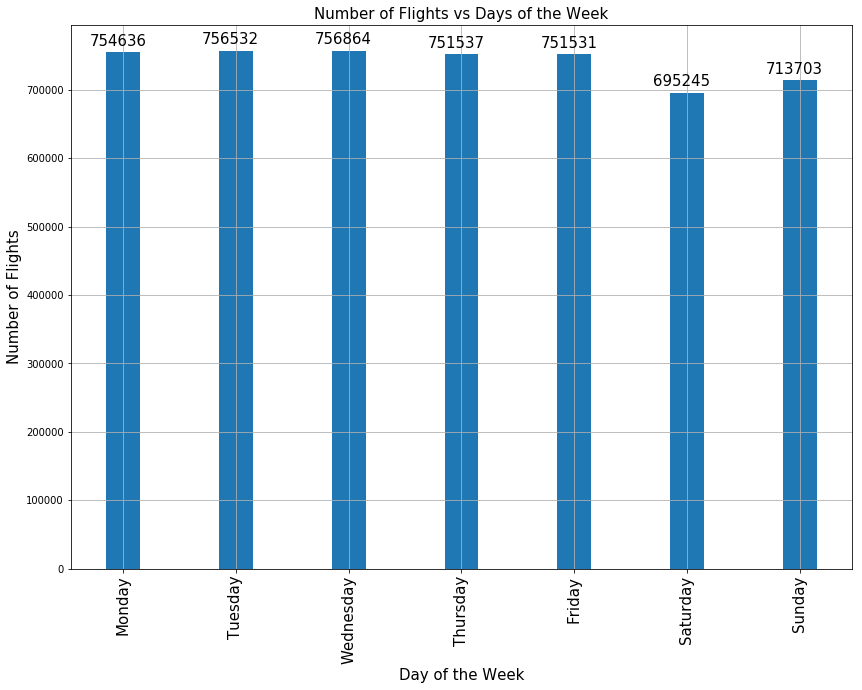

In [16]:
# group the days of the week and aggregate over the number of flights
# sort by day of the week
# convert the dataframe to a pandas dataframe

flightsPerDayofTheWeek = df.groupBy('day_of_week')\
.count()\
.orderBy("day_of_week")\
.toPandas()


# plot the number of flights per month
plt.figure(figsize = (14,10))
plt.grid(True)
plt.title("Number of Flights vs Days of the Week",fontsize=15)
plt.xlabel("Day of the Week",fontsize=15)
plt.ylabel("Number of Flights",fontsize=15)
plt.xticks(np.arange(1,8),['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],rotation='vertical',fontsize=15)
plt.bar(flightsPerDayofTheWeek["day_of_week"],
         flightsPerDayofTheWeek["count"],
        width = 0.3
        )
plt.yticks(fontsize=10)
for index, element in enumerate(flightsPerDayofTheWeek["count"]):
    plt.annotate(element,(index+0.7, element+10000),fontsize=15)

(array([     0.,  10000.,  20000.,  30000.,  40000.,  50000.,  60000.,
         70000.,  80000.]), <a list of 9 Text yticklabel objects>)

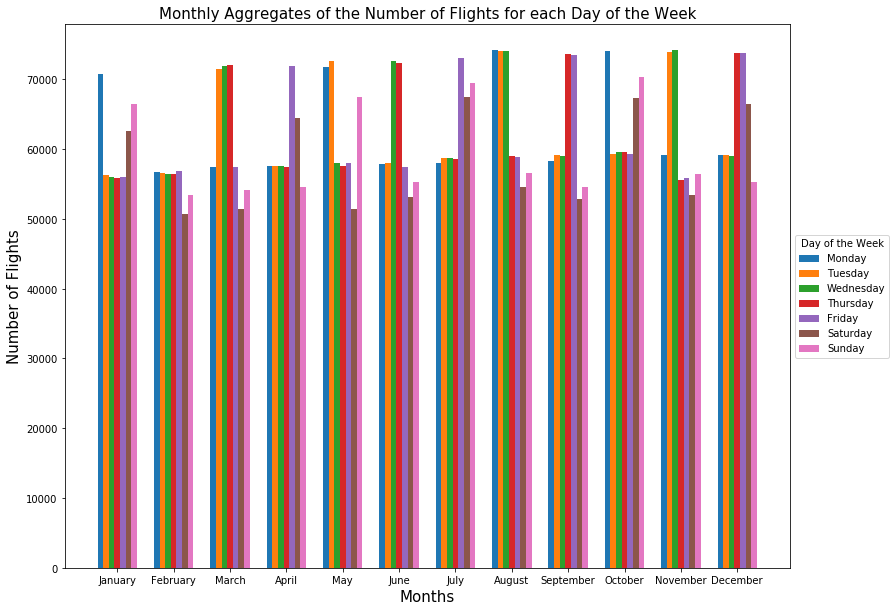

In [17]:
# group the months of the year and then days of the week within each month and aggregate over the number of flights
# sort by month and then by day
# convert the dataframe to a pandas dataframe
MonthlyAggFlightsPerDayofTheWeek = df.groupBy(['Month','day_of_week'])\
.count()\
.orderBy(["Month","day_of_week"])\
.toPandas()



# plot the number of flights per month (faster than seaborn usage)
plt.figure(figsize=(13,10))
plt.title("Monthly Aggregates of the Number of Flights for each Day of the Week",fontsize=15)
plt.xlabel("Months",fontsize=15)
plt.ylabel("Number of Flights",fontsize=15)
plt.xticks(np.arange(1,13),['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],fontsize=10)
for d in np.arange(1,8):
    plt.bar(np.arange(1,13) +0.1*(d-4),
             MonthlyAggFlightsPerDayofTheWeek[MonthlyAggFlightsPerDayofTheWeek.day_of_week == d]["count"],
            width=0.1
            )
plt.legend(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],loc='center left', bbox_to_anchor=(1, 0.5),title="Day of the Week")

plt.yticks(fontsize=10)

# plot the number of flights per month per day of the week
# axes = sns.catplot(x = 'Month',
#                    y = 'count',
#                    hue = 'day_of_week',
#                    kind = 'bar',
#                    data = MonthlyAggFlightsPerDayofTheWeek,
#                    legend_out = True,
#                    height = 7,
#                    aspect = 2
#                   )
# axes.set_axis_labels("Month", "Number of Flights")
# axes.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], rotation=0, fontsize = 13)


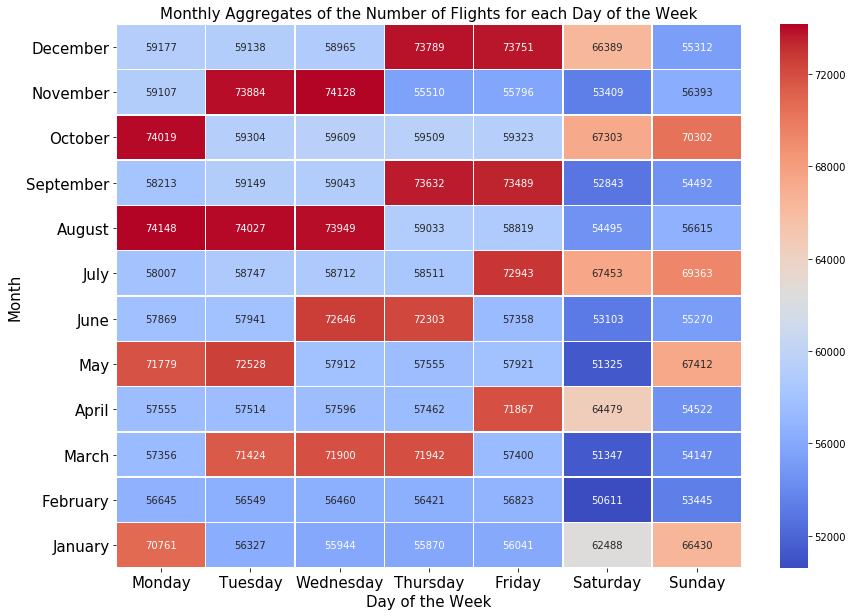

In [18]:
from mpl_toolkits.mplot3d import Axes3D

# print(flightsPerDayofTheWeek)

# setup the figure and axes
# fig = plt.figure(figsize=(35, 10))
# ax1 = fig.add_subplot(121, projection='3d')


# fracs = flightsPerDayofTheWeek['count']/float(flightsPerDayofTheWeek['count'].max())
# norm = mcolors.Normalize(fracs.min(), fracs.max())
# color_values = plt.cm.jet(norm(fracs.tolist()))

# ax1.bar3d(flightsPerDayofTheWeek['Month'], flightsPerDayofTheWeek['day_of_week'], np.zeros(84), 1, 1, flightsPerDayofTheWeek['count'], color = color_values,shade=True)
# ax1.set_title('Number of Flights for each Day of the Week of the Months of the Year')
# ax1.set_xticks(np.arange(1,13))
# ax1.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],rotation='vertical')
# ax1.set_yticks(np.arange(1,8))
# ax1.set_yticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax1.set_xlabel("Month")
# plt.show()

# construct a color map showing the monthly aggregates of the number of flights for each day of the week
# plt.figure(figsize=(14,10))
# plt.pcolormesh(flightsPerDayofTheWeek['count'].values.reshape(12,7),cmap = plt.get_cmap("coolwarm"))
# plt.grid(True)
# plt.colorbar()
# plt.xticks(np.arange(0,7),['\n\n\n\nMonday', '\n\n\n\nTuesday', '\n\n\n\nWednesday', '\n\n\n\nThursday', '\n\n\n\nFriday', '\n\n\n\nSaturday', '\n\n\n\nSunday'],rotation='vertical',fontsize=15)
# plt.yticks(np.arange(1,13),['\n\nJanuary', '\n\nFebruary', '\n\nMarch', '\n\nApril', '\n\nMay', '\n\nJune', '\n\nJuly', '\n\nAugust', '\n\nSeptember', '\n\nOctober', '\n\nNovember', '\n\nDecember'],fontsize=15)
# for (index1, index2), element in np.ndenumerate(flightsPerDayofTheWeek['count'].values.reshape(12,7)):
#     plt.annotate(element,(index2+0.3, index1+0.4),fontsize=15)
# plt.title("Monthly Aggregates of the Number of Flights for each Day of the Week",fontsize=15)
# plt.xlabel('Day of the Week',fontsize=15)
# plt.ylabel('Month',fontsize=15)
# plt.show()

# construct a color map showing the monthly aggregates of the number of flights for each day of the week
MonthlyAggFlightsPerDayofTheWeek_reshape = MonthlyAggFlightsPerDayofTheWeek.pivot("Month", "day_of_week", "count")
figure, axes = plt.subplots(figsize=(14,10))
axes = sns.heatmap(MonthlyAggFlightsPerDayofTheWeek_reshape,
                 cmap='coolwarm',
                 annot=True,
                 linewidths=.5,
                 fmt='d')
axes.invert_yaxis()
axes.set_title("Monthly Aggregates of the Number of Flights for each Day of the Week", fontsize=15)
axes.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontsize = 15)
axes.set_yticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], rotation=0, fontsize = 15)
plt.ylabel('Month',fontsize = 15)
plt.xlabel('Day of the Week',fontsize = 15)

plt.show()

### Interpretation

Considering only the days of the week across all times, the results show that weekends (Saturday and Sunday) witness less number of flights (around 700K on average) than weekdays (Monday to Friday) (around 750K on average)<br><br>

The monthly aggregates show quite different results than the global daily results where weekends have some peaks during some months like we can see in the numbers for January, July, and October. So the decreasing number of  weekend flights in the global daily results do not extend to monthly aggregates, but exists during some periods of the year like in February, March, June, August, September, and November.<br><br>

On the other hand, some months do not abide by any of the two patterns discussed previously (April, May, and December).
However, when constructing a color map for the monthly aggregates over the days of the week, more information and a new pattern can be observed.<br> Every month witnesses 2 to 3 consecutive peaks in the number of the flights (with the exception of February). These consecutive peaks shift each month backwards 2 to 3 days.<br>
Moreover, we can emphasize the previously seen fact that the number of flights is higher towards the second half of the year.

### Question 3.3

<div class="alert alert-info">
How many flights in different days of months and in different hours of days?  
<br>
<br>

<strong>NOTE:</strong> Similarly to the previous note, you need to compute both global statistcs and monthly statistics.

<br>
<br>
Plot  bar charts, and interpret your figures.
</div>

(array([      0.,   25000.,   50000.,   75000.,  100000.,  125000.,
         150000.,  175000.,  200000.]), <a list of 9 Text yticklabel objects>)

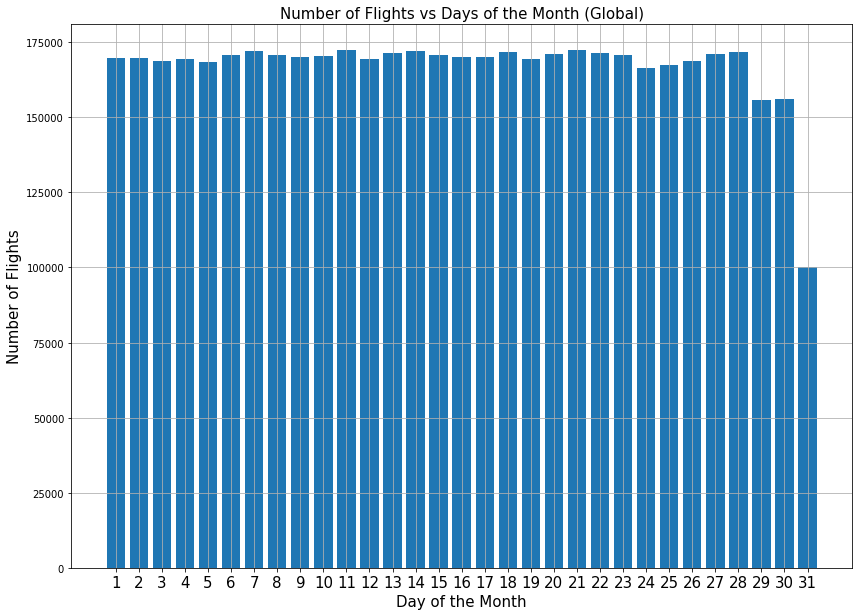

In [19]:
# group the days of the month
# aggregate over the number of flights
# sort by month and then by day
# convert the dataframe to a pandas dataframe
flightsPerDayoftheMonth = df.groupBy('day_of_month')\
.count()\
.orderBy('day_of_month')\
.toPandas()

# plot the number of flights per day of the month
plt.figure(figsize = (14,10))
plt.grid(True)
plt.title("Number of Flights vs Days of the Month (Global)",fontsize=15)
plt.xlabel("Day of the Month",fontsize=15)
plt.ylabel("Number of Flights",fontsize=15)
plt.xticks(np.arange(1,32),fontsize=15)
plt.bar(flightsPerDayoftheMonth["day_of_month"],
         flightsPerDayoftheMonth["count"]
        )
plt.yticks(fontsize=10)

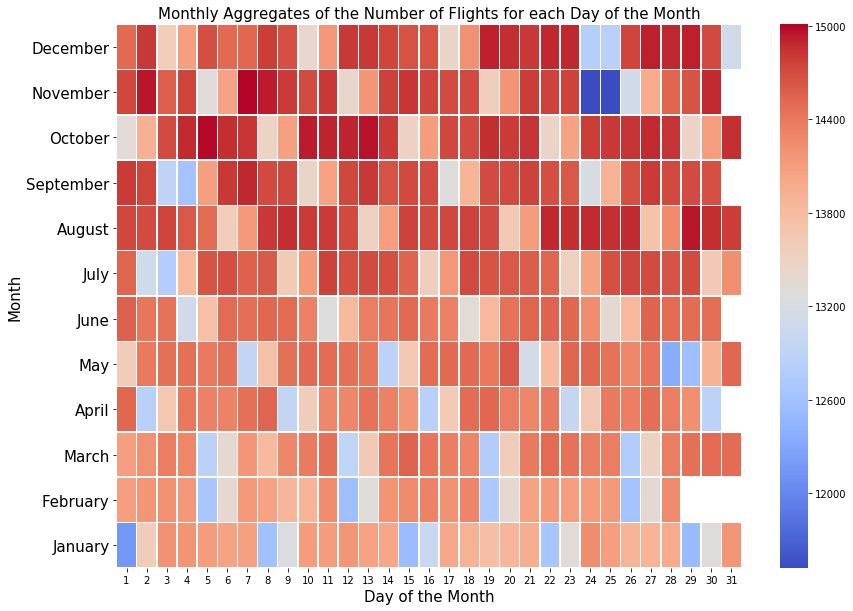

In [20]:
# group the months of the year and then the day within each month and aggregate over the number of flights
# sort by month and then by hour
# convert the dataframe to a pandas dataframe
MonthlyAggFlightsPerDayoftheMonthPerMonth = df.groupBy(['month','day_of_month'])\
.count()\
.orderBy(["month","day_of_month"])\
.toPandas()

# flights = np.zeros((12,31))

# for index, element in flightsPerHouroftheDayPerMonth.iterrows():
#     flights[element['month']-1,element['day_of_month']-1] = element['count']

# # construct a color map showing the monthly aggregates of the number of flights for each day of the month
# plt.figure(figsize=(14,10))
# plt.pcolormesh(flights,cmap = plt.get_cmap("coolwarm"))
# plt.grid(True)
# plt.colorbar()
# plt.xticks(np.arange(1,32),rotation = 40)
# # plt.xticks(np.arange(0.5,31.5),['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31'],fontsize=10)
# plt.yticks(np.arange(1,13),['\n\nJanuary', '\n\nFebruary', '\n\nMarch', '\n\nApril', '\n\nMay', '\n\nJune', '\n\nJuly', '\n\nAugust', '\n\nSeptember', '\n\nOctober', '\n\nNovember', '\n\nDecember'],fontsize=15)
# plt.title("Monthly Aggregates of the Number of Flights for each Day of the Month",fontsize=15)
# plt.xlabel('Day of the Month',fontsize=15)
# plt.ylabel('Month',fontsize=15)
# plt.show()

# construct a color map showing the monthly aggregates of the number of flights for each day of the month
MonthlyAggFlightsPerDayoftheMonthPerMonth_reshape = MonthlyAggFlightsPerDayoftheMonthPerMonth.pivot("month", "day_of_month", "count")
figure, axes = plt.subplots(figsize=(14,10))
axes = sns.heatmap(MonthlyAggFlightsPerDayoftheMonthPerMonth_reshape,
                 cmap='coolwarm',
                 linewidths=.5,
                 fmt='d')
axes.invert_yaxis()
axes.set_title("Monthly Aggregates of the Number of Flights for each Day of the Month", fontsize=15)
axes.set_yticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], rotation=0, fontsize = 15)
plt.ylabel('Month',fontsize = 15)
plt.xlabel('Day of the Month',fontsize = 15)
plt.show()

### Interpretation (Days of the Month)

The global statistics of the number of flights over the days of the month is quite stable and there seems to be no interesting pattern about the obtained plot. The decreased number of the last three days of the month is due to the fact that not all months are 31 days and February has less than 30 days (28 or 29)<br>
However, when we study the monthly statistics of the days of the month, a pattern appears. This shows that studying the data globaly over the days of the month hides that pattern.<br>
The monthly statistics of the number of flights for the days of the month show a pattern which already appeard in the study of the monthly statistics of the days of the week. The number of flights takes higher values for 5 consecutive days and then drops for two consecutive days. This confirms the observations in Part 3.2 where the flight numbers drop during the weekend (Saturday and Sunday) and also what was seen in Part 3.1 since we can see higher numbers towards the second half of the year.

(array([      0.,   50000.,  100000.,  150000.,  200000.,  250000.,
         300000.,  350000.,  400000.,  450000.]),
 <a list of 10 Text yticklabel objects>)

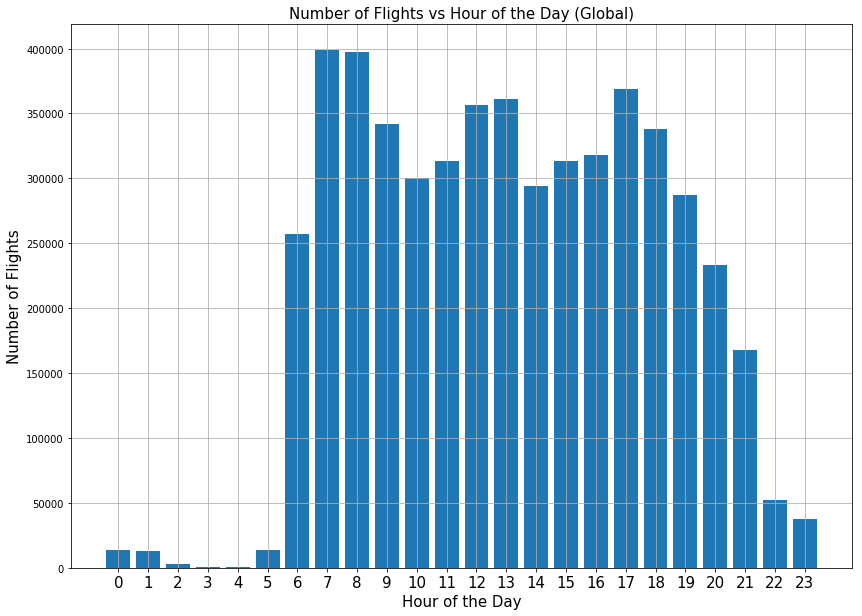

In [21]:
# alter the column of the scheduled departure time in the view only by
# extracting the hours value
# take the integer part
# do a modulo(24) operation to take out the hour value '24' and include it in the hour value '0'
# give the modified column as alias
# group the modified column representing the hours of the day
# aggregate over the number of flights
# sort by hour of the day
# convert the dataframe to a pandas dataframe
flightsPerHouroftheDay = df.groupBy((((df['scheduled_departure_time']/100).cast('int'))%24).alias('Hour_of_the_Day'))\
.count()\
.toPandas()

# print(flightsPerHouroftheDay)

# plot the number of flights per day of the month
plt.figure(figsize = (14,10))
plt.grid(True)
plt.title("Number of Flights vs Hour of the Day (Global)",fontsize=15)
plt.xlabel("Hour of the Day",fontsize=15)
plt.ylabel("Number of Flights",fontsize=15)
plt.xticks(np.arange(0,24),fontsize=15)
plt.bar(flightsPerHouroftheDay["Hour_of_the_Day"],
         flightsPerHouroftheDay["count"]
        )
plt.yticks(fontsize=10)



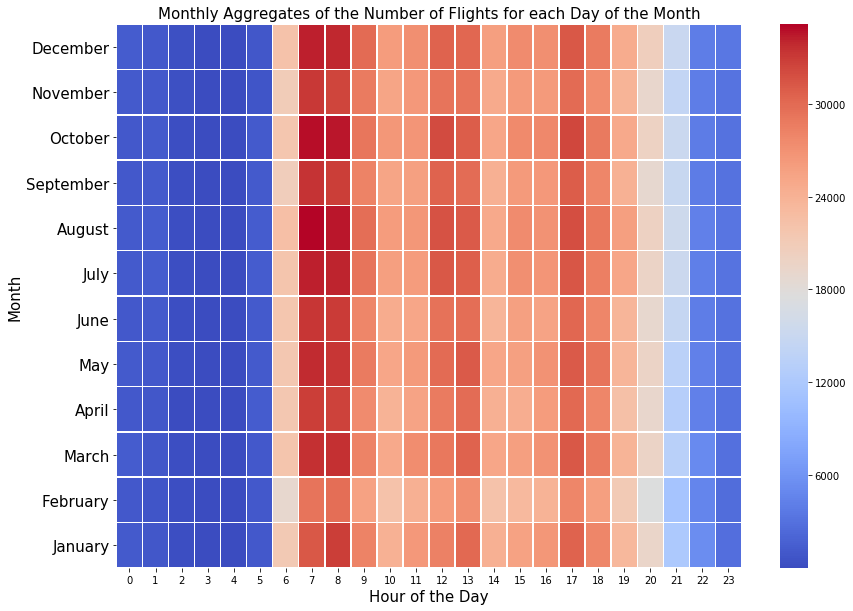

In [22]:
# group the months of the year and then hour of the day within each month and aggregate over the number of flights
# sort by month and then by hour
# convert the dataframe to a pandas dataframe
MonthlyAggFlightsPerHouroftheDay = df.groupBy(df.month,(((df['scheduled_departure_time']/100).cast('int'))%24).alias('Hour_of_the_Day'))\
.count()\
.orderBy(["month","Hour_of_the_Day"])\
.toPandas()


# construct a color map showing the monthly aggregates of the number of flights for each hour of the day
# plt.figure(figsize=(14,10))
# plt.pcolormesh(flightsPerHouroftheDayPerMonth['count'].values.reshape(12,24),cmap = plt.get_cmap("coolwarm"))
# plt.grid(True)
# plt.colorbar()
# plt.xticks(np.arange(0,24),rotation=40,fontsize=15)
# plt.yticks(np.arange(1,13),['\n\nJanuary', '\n\nFebruary', '\n\nMarch', '\n\nApril', '\n\nMay', '\n\nJune', '\n\nJuly', '\n\nAugust', '\n\nSeptember', '\n\nOctober', '\n\nNovember', '\n\nDecember'],fontsize=15)
# plt.title("Monthly Aggregates of the Number of Flights for each Hour of the Day",fontsize=15)
# plt.xlabel('Hour of the Day',fontsize=15)
# plt.ylabel('Month',fontsize=15)
# plt.show()

# construct a color map showing the monthly aggregates of the number of flights for each hour of the day
MonthlyAggFlightsPerHouroftheDay_reshape = MonthlyAggFlightsPerHouroftheDay.pivot("month", "Hour_of_the_Day", "count")
figure, axes = plt.subplots(figsize=(14,10))
axes = sns.heatmap(MonthlyAggFlightsPerHouroftheDay_reshape,
                 cmap='coolwarm',
                 linewidths=.5,
                 fmt='d')
axes.invert_yaxis()
axes.set_title("Monthly Aggregates of the Number of Flights for each Day of the Month", fontsize=15)
axes.set_yticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], rotation=0, fontsize = 15)
plt.ylabel('Month',fontsize = 15)
plt.xlabel('Hour of the Day',fontsize = 15)
plt.show()

### Interpretation (Hours of the Day)

The hourly number of flights without regarding the months of the year show a higher number of flights during the day (6h00 to 18h00), with peak hours at 7h00 and 8h00, that then decrease starting from 19h00 in the evening until reaching very low values from 22h00 to 5h00 in the morning.<br>
Now, when moving to the monthly statistics of the hourly number of flights, the color map also shows higher flight numbers during the day, and these numbers also decrease by evening until reaching very low values from 22h00 to 5h00 in the morning and the pattern is quite uniform among all the months of the year.<br>
This signifies passengers highly prefer day flights over night flights regardless of the month they're in which leads to carriers providing less night flights.

### Question 3.4

<div class="alert alert-info">
Which are the **top 20** busiest airports? Compute this in terms of the inbound, outbound and total number of flights.
</div>

In [8]:
# group according to the origin airport and aggregate over the number of flights
# cache the dataframe for later use
airpots_in_density = df.groupBy(df.src_airport.alias('Airport'))\
.count()\
.orderBy(desc("count"))\
.cache()

# group according to the destination airport and aggregate over the number of flights
# cache the dataframe for later use
airpots_out_density = df.groupBy(df.dest_airport.alias('Airport'))\
.count()\
.orderBy(desc("count"))\
.cache()


print("The top 20 busiest airports with inbound flights:")
airpots_in_density.show(20)

print("--------------------------------------------------\n\n")
print("The top 20 busiest airports with outbound flights:")
airpots_out_density.show(20)

print("--------------------------------------------------\n\n")
print("The top 20 busiest airports:")
# perform a union operation to stack the two dataframes vertically
# group identical airport names and aggregate by summing the number of flights
# sort according to decreasing number of flights
# display the top 20 results
busiest_airports = airpots_in_density\
.union(airpots_out_density)\
.groupBy('Airport')\
.sum()\
.orderBy(desc('sum(count)'))

busiest_airports.show()

The top 20 busiest airports with inbound flights:
+-------+------+
|Airport| count|
+-------+------+
|    ORD|277741|
|    DFW|256274|
|    ATL|221486|
|    LAX|153494|
|    STL|151609|
|    DEN|141427|
|    PHX|139581|
|    DTW|136837|
|    PIT|130977|
|    CLT|129391|
|    MSP|123222|
|    SFO|118233|
|    EWR|116768|
|    IAH|104182|
|    LGA|101864|
|    BOS|100365|
|    LAS| 94972|
|    PHL| 93585|
|    DCA| 88445|
|    MCO| 77120|
+-------+------+
only showing top 20 rows

--------------------------------------------------


The top 20 busiest airports with outbound flights:
+-------+------+
|Airport| count|
+-------+------+
|    ORD|283720|
|    DFW|260249|
|    ATL|221588|
|    LAX|152959|
|    STL|152800|
|    DEN|144099|
|    PHX|140979|
|    DTW|139435|
|    PIT|131962|
|    CLT|130321|
|    MSP|124758|
|    SFO|117245|
|    EWR|117223|
|    IAH|104409|
|    LGA|101498|
|    BOS| 99331|
|    LAS| 94948|
|    PHL| 93312|
|    DCA| 87670|
|    MCO| 76600|
+-------+------+
only

### Question 3.5
<div class="alert alert-info">
Which are the **top 20** busiest carriers? Compute this in terms of number of flights.
</div>


In [98]:
# group according to the carrier and aggregate over the number of flights
# sort in the decreasing number of flights
# display the top 20 carriers
Busiest_carriers = (
                    df.groupBy('carrier')\
                    .count()\
                    .orderBy(desc('count'))           
                    )
Busiest_carriers.show(20)

+-------+------+
|carrier| count|
+-------+------+
|     DL|874526|
|     US|857906|
|     AA|722277|
|     UA|638750|
|     WN|565426|
|     CO|484834|
|     NW|482798|
|     TW|258205|
|     HP|177851|
|     AS|117475|
+-------+------+



## Question 4 
In this series of questions we focus on the computation of statistics about the percentage of delayed flights.

### Question 4.1
<div class="alert alert-info">
What is the percentage of delayed flights for different hours of the day?  

Plot a bar chart and interpret the figure.  


<div class="label label-success">IMPORTANT!</div> A flight is considered as delayed if it's actual arrival time is more than 15 minutes later than the scheduled arrival time.

</div>

In [25]:
# df1= df.toPandas()
# df1.to_csv('./data.csv')

In [26]:
# df1[df1.arrival_delay > 15]

In [27]:
# Number of delayed flights per hour
df_flights_hour_delay = df[df.arrival_delay > 15]\
.groupBy((df.scheduled_departure_time/100).cast('int').alias('hour'))\
.count()

# Number of flights per hour
df_flights_hour = df.groupBy((df.scheduled_departure_time/100).cast('int').alias('hour'))\
.count()

# Percentage of delayed flights per hour
percentage_hour_delay = (
    df_flights_hour.join(df_flights_hour_delay, df_flights_hour.hour == df_flights_hour_delay.hour, 'inner')
    .select(df_flights_hour.hour, (df_flights_hour_delay['count']*100/df_flights_hour['count']).alias('Delay % per Hour'))
    .orderBy('hour')
    .collect()
)


<BarContainer object of 24 artists>

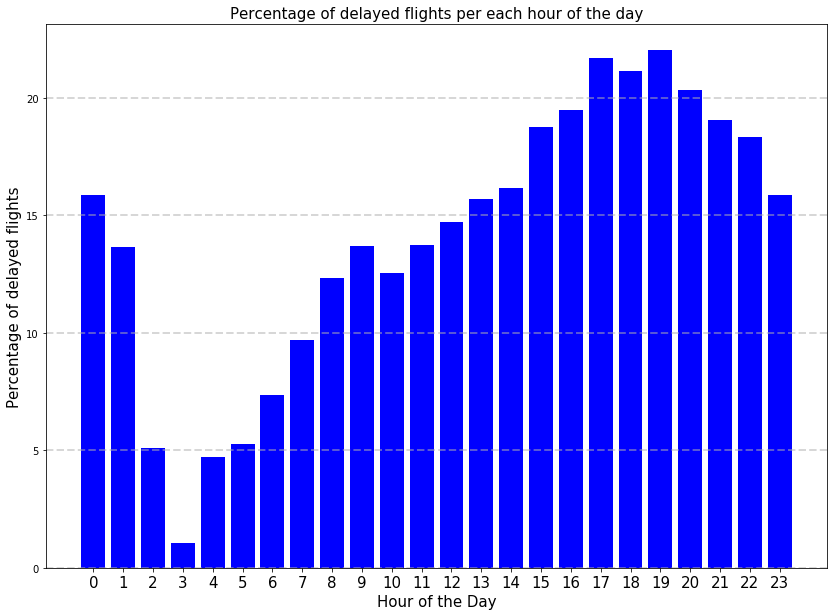

In [28]:
percentage_hour_delay_pd = pd.DataFrame(data=percentage_hour_delay, columns=['hour', 'Delay % per Hour'])

# plot the percentage of flights in delay per hour
plt.figure(figsize = (14,10))
plt.grid(True, axis='y', linestyle='--',alpha = 0.5,linewidth=2)
plt.title("Percentage of delayed flights per each hour of the day",fontsize=15)
plt.xlabel("Hour of the Day",fontsize=15)
plt.ylabel("Percentage of delayed flights",fontsize=15)
plt.xticks(np.arange(0,24),fontsize=15)
plt.bar(percentage_hour_delay_pd["hour"],
         percentage_hour_delay_pd["Delay % per Hour"]
        ,color='b')

### Interpretatnotion:
    
By looking at the plot above, we can notice that the percentage starts to increase at 3:00 AM and reaches its peak between 17:00 and 19:00 (almost one flight out of five), then it decreases again. 
    
Our results before showed that the number of flights at night are low. This plot did not provide us a clear image about the relation between the number of flights and the percentage of delay, where the peak hour delay is at 19:00 which is counted as a night flight. The same result if we compared the number of flights at 21:00 which is very low where the percenatge of delay is high at this time. So, to get a better intuition about delays it would be better to look at actual average values of the delay.

Also, by observing the increase in the percentage of delay starting from ~ 3:00 until is reaches it's maximum before 20:00. We assume that the delay could be cumulative among flights,in other words, the delay of a flight may affect the delay of other flights arriving at the same airport in a similar time range. 

### Question 4.2
<div class="alert alert-info">
You will realize that saying *"at 4 A.M. there is a very low chance of a flight being delayed"* is not giving you a full picture of the situation. Indeed, it might be true that there is very little probability for an early flight to be delayed, but if it does, the delay might be huge, like 6 hours!  

<ul></ul>

Then, the question is: **which hours of the day are characterized by the largest mean delay?** (you can consider the median too)  

Plot a Bar chart and explain it.  

</div>

In [29]:
# average delay per hour
avg_delay_per_hour = (
    df.groupBy(((df.scheduled_departure_time/100)).cast('int').alias('hour'))
    .avg('arrival_delay')
    .orderBy('hour')
    .collect()
)

<BarContainer object of 25 artists>

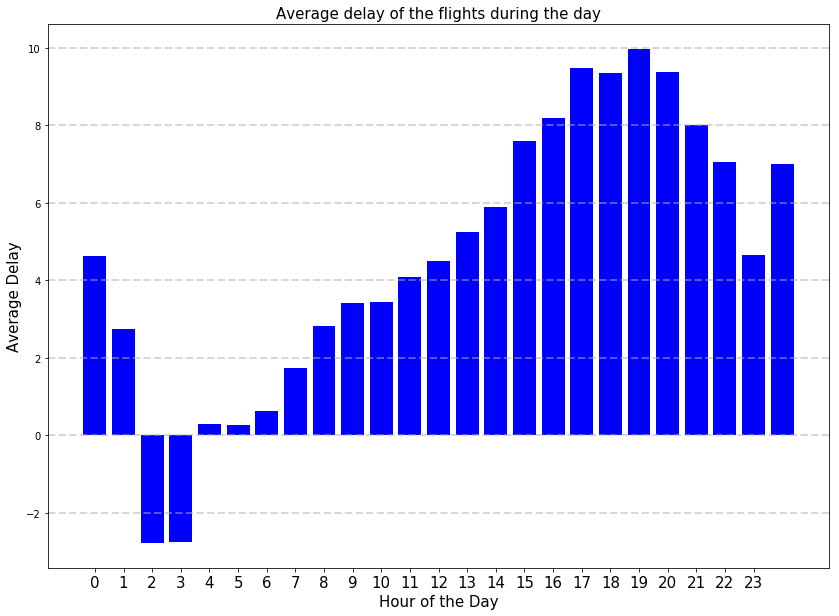

In [30]:
avg_delay_per_hour_pd = pd.DataFrame(data=avg_delay_per_hour, columns=['hour', 'avg'])


# plot the percentage of flights in delay per hour
plt.figure(figsize = (14,10))
plt.grid(True, axis='y', linestyle='--',alpha = 0.5,linewidth=2)
plt.title("Average delay of the flights during the day",fontsize=15)
plt.xlabel("Hour of the Day",fontsize=15)
plt.ylabel("Average Delay",fontsize=15)
plt.xticks(np.arange(0,24),fontsize=15)
plt.bar(avg_delay_per_hour_pd["hour"],
         avg_delay_per_hour_pd["avg"]
        ,color='b')

### Interpretation:

By looking at the plot above, we can notice:
<br>

<b>1 A negative values of delay between 2 AM and 3 AM.</b><br>
This means that the flights arrive earlier than the scheduled time. So some students may missunderstand the definition of the delay.

<b>2 A siginificant increase in the average delay starting from 7 AM until 8 PM.</b><br>
    The flights in the morning have less delay compared with afternoon and evening. Which match our interpretation in the question before.

<b>3 A Correlation between the percentage of delayed fligts and the average value of delays can be seen.</b><br>
The information from this plot is coherent with what we've already seen,  knowing that night hours have less flights and the shape of this curve is closer to the one of the previous one. In conclusion, we can notice this correlation.

With data of year 1994, the flight from 3AM to 4AM often depart earlier than in their schedule. The flights in the morning have less delay then in the afternoon and evening.

So, an attentive student should notice here that we have somehow a problem with the definition of delay! Next, we will improve how to represent and visualize data to overcome this problem.

**NOTE**: the following piece of code assumes you correctly answered the previous questions. The naming convention of the DataFrames we use next should be clear enough for you to produce them by answering the questions above.

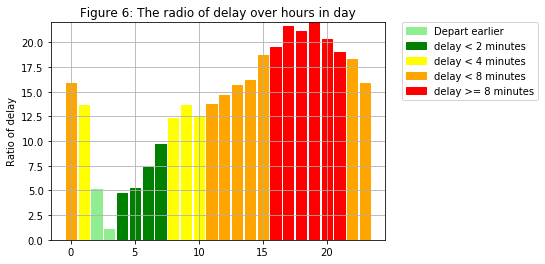

In [31]:
#pdf2 = pd.DataFrame(data=mean_delay_per_hour.collect())
pdf_delay_ratio_per_hour =  pd.DataFrame(data=percentage_hour_delay)
pdf_mean_delay_per_hour =  pd.DataFrame(data=avg_delay_per_hour)

plt.ylabel("Ratio of delay")
plt.title('Figure 6: The radio of delay over hours in day')
plt.grid(True,which="both",ls="-")
bars = plt.bar(pdf_delay_ratio_per_hour[0], pdf_delay_ratio_per_hour[1], align='center', edgecolor = "black")
for i in range(0, len(bars)):
    color = 'red'
    if pdf_mean_delay_per_hour[1][i] < 0:
        color = 'lightgreen'
    elif pdf_mean_delay_per_hour[1][i] < 2:
        color = 'green'
    elif pdf_mean_delay_per_hour[1][i] < 4:
        color = 'yellow'
    elif pdf_mean_delay_per_hour[1][i] < 8:
        color = 'orange'

    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='Depart earlier')
patch2 = mpatches.Patch(color='green', label='delay < 2 minutes')
patch3 = mpatches.Patch(color='yellow', label='delay < 4 minutes')
patch4 = mpatches.Patch(color='orange', label='delay < 8 minutes')
patch5 = mpatches.Patch(color='red', label='delay >= 8 minutes')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.margins(0.05, 0)
plt.show()

In the new figure (Figure 6), we have more information in a single plot. The flights in 3AM to 4AM have very low probability of being delayed, and actually depart earlier than their schedule. In contrast, the flights in the 4PM to 8PM range have higher chances of being delayed: in more than 50% of the cases, the delay is 8 minutes or more.

This example shows us that the way representing results are also important.


### Question 4.3

<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over days in a month. Discuss your findings from the figure.
</div>

In [14]:
Delayed_per_MonthDays = (df[df.arrival_delay > 15]\
                        .groupBy(df.day_of_month)\
                        .count()
                        .orderBy('day_of_month')
                       )

flights_per_MonthDays = df.groupBy(df.day_of_month).count().orderBy('day_of_month')

# Delayed_per_MonthDays.show()
# flights_per_MonthDays.show()

Percentage_delayed_per_MonthDays = (
                     
    flights_per_MonthDays.join(Delayed_per_MonthDays,Delayed_per_MonthDays['day_of_month']==flights_per_MonthDays['day_of_month'], 'inner').select(flights_per_MonthDays.day_of_month,(Delayed_per_MonthDays['count']/flights_per_MonthDays['count'])*100).orderBy("day_of_month").collect()

                                  )

<BarContainer object of 31 artists>

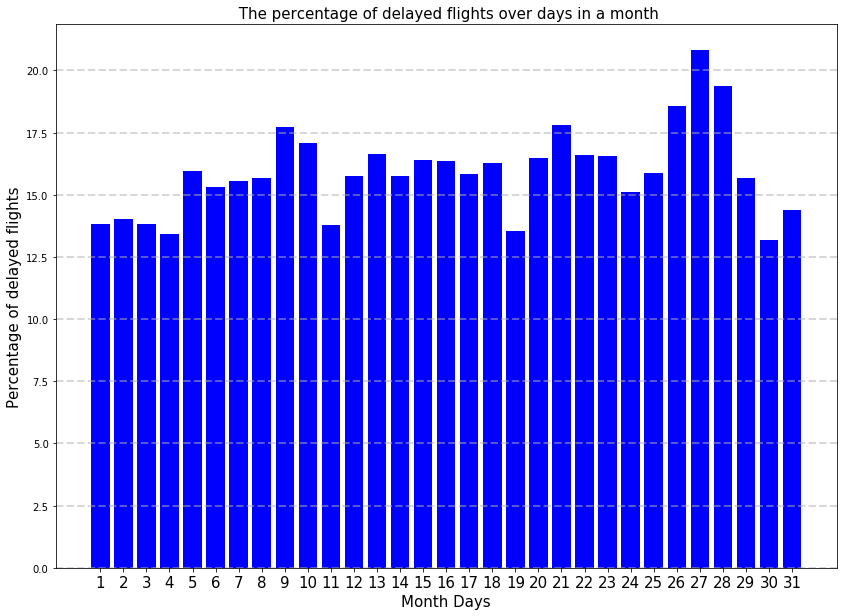

In [15]:
Percentage_delayed_per_MonthDays_pd = pd.DataFrame(data=Percentage_delayed_per_MonthDays, columns=['hour', 'Delay % per Days in month'])

# plot the percentage of flights in delay per hour
plt.figure(figsize = (14,10))
plt.grid(True, axis='y', linestyle='--',alpha = 0.5,linewidth=2)
plt.title(" The percentage of delayed flights over days in a month",fontsize=15)
plt.xlabel("Month Days",fontsize=15)
plt.ylabel("Percentage of delayed flights",fontsize=15)
plt.xticks(np.arange(1,32),fontsize=15)
plt.bar(Percentage_delayed_per_MonthDays_pd["hour"],
         Percentage_delayed_per_MonthDays_pd["Delay % per Days in month"]
        ,color='b')

### Interpretation:

The percentage of delayed flights oscillates around <b>15%</b> over the days of month. Also, by looking at the oscillation pattern, we can notice a periodical drops and peaks, we expect this related to the days of the week during the month.

Knowing that the day of the month is not constant, where the values from the 29th to the 31st is not always counted.  We can then observe an increase in the percenatge delayed flight in the last 10 days of the month.


### Question 4.4

<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over days in a week. Discuss your findings from the figure.
</div>

In [13]:
Delayed_per_WeekDays = (df[df.arrival_delay > 15]\
                        .groupBy(df.day_of_week)\
                        .count()
                        .orderBy('day_of_week')
                       )

flights_per_WeekDays = df.groupBy(df.day_of_week).count().orderBy('day_of_week')

Delayed_per_WeekDays.show()
flights_per_WeekDays.show()

Percentage_delayed_per_WeekDays = (
                     
    flights_per_WeekDays.join(Delayed_per_WeekDays,Delayed_per_WeekDays['day_of_week']==flights_per_WeekDays['day_of_week'], 'inner')\
    .select(flights_per_WeekDays.day_of_week,(Delayed_per_WeekDays['count']/flights_per_WeekDays['count'])*100).orderBy("day_of_week")\
    .collect()
)
                                

+-----------+------+
|day_of_week| count|
+-----------+------+
|          1|115725|
|          2|108355|
|          3|129154|
|          4|139747|
|          5|137358|
|          6| 91702|
|          7|103824|
+-----------+------+

+-----------+------+
|day_of_week| count|
+-----------+------+
|          1|754636|
|          2|756532|
|          3|756864|
|          4|751537|
|          5|751531|
|          6|695245|
|          7|713703|
+-----------+------+

<class 'pyspark.sql.dataframe.DataFrame'>


<BarContainer object of 7 artists>

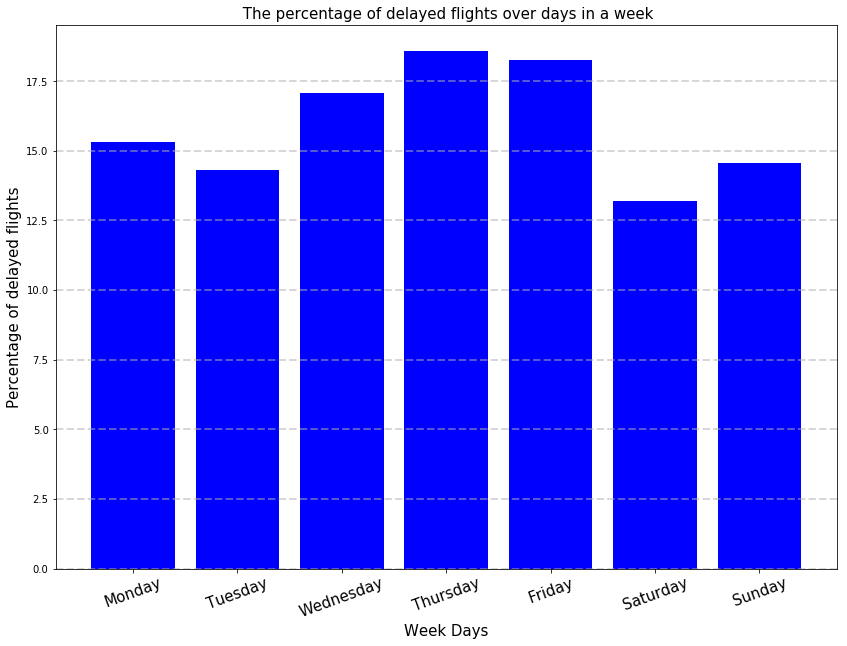

In [35]:
Percentage_delayed_per_WeekDays_pd = pd.DataFrame(data=Percentage_delayed_per_WeekDays, columns=['hour', 'Delay % per Week Days'])

# plot the percentage of flights in delay per hour
plt.figure(figsize = (14,10))
plt.grid(True, axis='y', linestyle='--',alpha = 0.5,linewidth=2)
plt.title(" The percentage of delayed flights over days in a week",fontsize=15)
plt.xlabel("Week Days",fontsize=15)
plt.ylabel("Percentage of delayed flights",fontsize=15)
plt.xticks(np.arange(1,8),['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],fontsize=15, rotation = 20)
plt.bar(Percentage_delayed_per_WeekDays_pd["hour"],
         Percentage_delayed_per_WeekDays_pd["Delay % per Week Days"]
        ,color='b')

### Interpretation

As our assumption in the previous question, the percentage of delayed flights is higher in the middle of the week and it shows a decrease at the beginning and at the end. This is the reason behind the periodical oscillation pattern in the previous plot(The percentage of delayed flights over days in a month).  

We can also notice that the percentage of delayed flights hits its minimum during the weekend, which is understandable as we already saw in the previous results that there is less flights during this period.

### Question 4.5
<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over months in a year. Discuss your findings from the figure.
</div>

In [36]:
Delayed_per_Month = (df[df.arrival_delay > 15]\
                        .groupBy(df.month)\
                        .count()
                        .orderBy('month')
                       )

flights_per_Month = df.groupBy(df.month).count().orderBy('month')

Delayed_per_Month.show()
flights_per_Month.show()

Percentage_delayed_per_Month = (
                     
    flights_per_Month.join(Delayed_per_Month,Delayed_per_Month['month']==flights_per_Month['month'], 'inner')\
    .select(flights_per_Month.month,(Delayed_per_Month['count']/flights_per_Month['count'])*100).orderBy("month")\
    .collect()
)

             

+-----+-----+
|month|count|
+-----+-----+
|    1|97957|
|    2|78600|
|    3|65260|
|    4|63986|
|    5|47542|
|    6|69084|
|    7|81022|
|    8|64893|
|    9|45590|
|   10|55901|
|   11|73947|
|   12|82083|
+-----+-----+

+-----+------+
|month| count|
+-----+------+
|    1|423861|
|    2|386954|
|    3|435516|
|    4|420995|
|    5|436432|
|    6|426490|
|    7|443736|
|    8|451086|
|    9|430861|
|   10|449369|
|   11|428227|
|   12|446521|
+-----+------+



<BarContainer object of 12 artists>

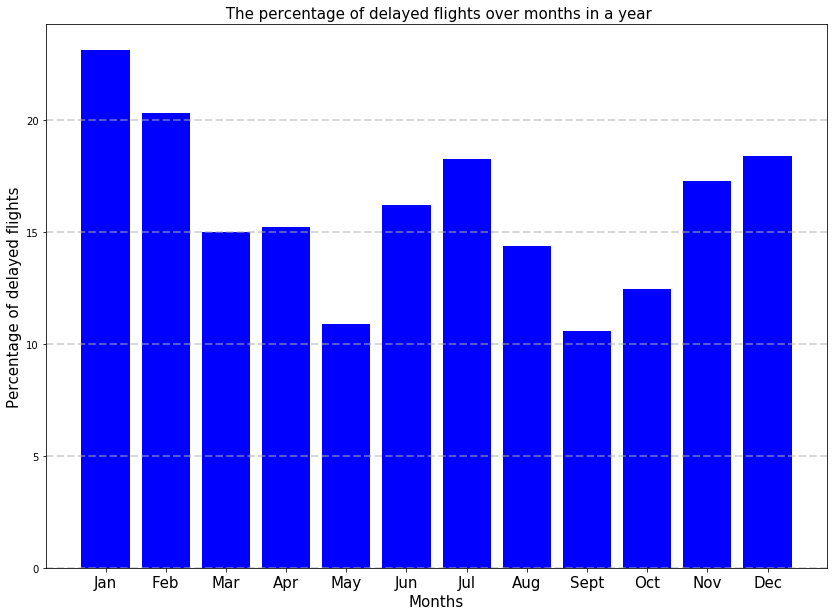

In [37]:
Percentage_delayed_per_Month_pd = pd.DataFrame(data=Percentage_delayed_per_Month, columns=['hour', 'Delay % per Month'])

# plot the percentage of flights in delay per hour
plt.figure(figsize = (14,10))
plt.grid(True, axis='y', linestyle='--',alpha = 0.5,linewidth=2)
plt.title(" The percentage of delayed flights over months in a year",fontsize=15)
plt.xlabel("Months",fontsize=15)
plt.ylabel("Percentage of delayed flights",fontsize=15)
plt.xticks(np.arange(1,13),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'],fontsize=15)
plt.bar(Percentage_delayed_per_Month_pd["hour"],
         Percentage_delayed_per_Month_pd["Delay % per Month"]
        ,color='b')

We are ready now to draw some observations from our data, even if we have only looked at data coming from a year worth of flights:

- The probability for a flight to be delayed is low at the beginning or at the very end of a given months
- Flights on two first weekdays and on the weekend, are less likely to be delayed
- May and September are very good months for travelling, as the probability of delay is low (remember we're working on US data. Do you think this is also true in France?)

Putting things together, we can have a global picture of the whole year!

In [3]:
df_with_delay = df.withColumn('is_delay', when(df["arrival_delay"] >= 15, 1).otherwise(0))
statistic_day = df_with_delay.groupBy(['year','month', 'day_of_month', 'day_of_week'])\
    .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))

# assume that we do statistic on year 1994
statistic_day = statistic_day\
    .orderBy('year', 'month', 'day_of_month', 'day_of_week')
pdf = pd.DataFrame(data=statistic_day.collect())

        0   1   2  3         4
0    1994   1   1  6  0.121484
1    1994   1   2  7  0.249577
2    1994   1   3  1  0.316953
3    1994   1   4  2  0.253472
4    1994   1   5  3  0.320918
5    1994   1   6  4  0.316606
6    1994   1   7  5  0.243818
7    1994   1   8  6  0.163427
8    1994   1   9  7  0.196553
9    1994   1  10  1  0.195652
10   1994   1  11  2  0.200411
11   1994   1  12  3  0.303967
12   1994   1  13  4  0.254373
13   1994   1  14  5  0.259518
14   1994   1  15  6  0.130622
15   1994   1  16  7  0.276416
16   1994   1  17  1  0.306501
17   1994   1  18  2  0.273498
18   1994   1  19  3  0.285787
19   1994   1  20  4  0.302062
20   1994   1  21  5  0.206234
21   1994   1  22  6  0.101059
22   1994   1  23  7  0.136844
23   1994   1  24  1  0.174423
24   1994   1  25  2  0.218615
25   1994   1  26  3  0.309078
26   1994   1  27  4  0.393276
27   1994   1  28  5  0.357378
28   1994   1  29  6  0.192912
29   1994   1  30  7  0.274829
..    ...  ..  .. ..       ...
335  199

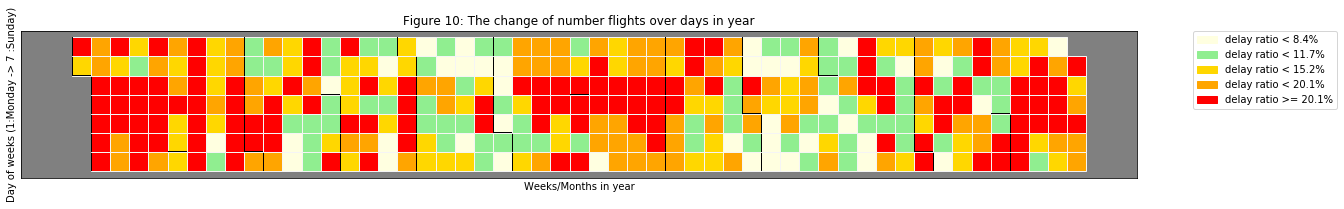

In [11]:
print(pdf)
fig = plt.figure(figsize=(20,10))                                                             
ax = fig.add_subplot(1,1,1)     
plt.xlabel("Weeks/Months in year")
plt.ylabel("Day of weeks (1:Monday -> 7 :Sunday)")
plt.title('Figure 10: The change of number flights over days in year')
  
rec_size = 0.3
from matplotlib.patches import Rectangle
import datetime
num_days = len(pdf[0])
ax.patch.set_facecolor('gray')
ax.set_aspect('equal', 'box')
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())

for i in range(0, num_days):
    # extract information from the result
    year = pdf[0][i]
    month = pdf[1][i]
    day_of_month = pdf[2][i]
    day_of_week = pdf[3][i]
    day_of_year= datetime.date(year=year, month=month, day=day_of_month).timetuple()
    week_of_year = datetime.date(year=year, month=month, day=day_of_month).isocalendar()[1]
    
    # dealing with the week of the previous year
    if week_of_year == 52 and month == 1:
        week_of_year = 0
        
    # the coordinate of a day in graph
    X = week_of_year*rec_size
    Y = day_of_week*rec_size
    
    # use different colors to show the delay ratio
    color = 'white'
    if pdf[4][i] <= 0.084:
        color = 'lightyellow'
    elif pdf[4][i] <= 0.117:
        color = 'lightgreen'
    elif pdf[4][i] <= 0.152:
        color = 'gold'
    elif pdf[4][i] <= 0.201:
        color = 'orange'
    else:
        color = 'red'
    rect = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, rec_size,
                      alpha=1, facecolor=color, edgecolor='whitesmoke')

    ax.add_patch(rect)
    
    # drawing boders to separate months
    if day_of_month <= 7:
        rect2 = plt.Rectangle((X -rec_size/2.0, Y - rec_size/2.0), 0.01, rec_size,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
    if day_of_month == 1:
        rect2 = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, 0.01,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
ax.autoscale_view()

patch1 = mpatches.Patch(color='lightyellow', label='delay ratio < 8.4%')
patch2 = mpatches.Patch(color='lightgreen', label='delay ratio < 11.7%')
patch3 = mpatches.Patch(color='gold', label='delay ratio < 15.2%')
patch4 = mpatches.Patch(color='orange', label='delay ratio < 20.1%')
patch5 = mpatches.Patch(color='red', label='delay ratio >= 20.1%')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

### Interpretation

The plot above shows that the percentage of delays is high in November, Decemeber, January and February. Winter season can be a correlation between this 4 months, so we expect that this delay is due to the bad weather condition during this period of the year. Also, July achieves a peak and this is because of the summer vacations where the number of flights start to increase gradually causing airline traffic. However, May and September achieve the lowest percentage of delay.

As we know, in France, the winter season starts in December untill February, which means we may expect a high % of delayed flights as the previous plot. But in the other periods it may differ depending on the holidays and other aspects. For example, In USA, it shows that in May is the lowest percentage while we expect a higher percentage of delayed flights in France due to the high amount of holidays in this month. 

### Question 4.6
<div class="alert alert-info">

What is the delay probability for the top 20 busiest airports?  


By drawing the flight volume of each airport and the associated delay probability in a single plot, we can observe the relationship between airports, number of flights and the delay.  

<div class="label label-success">HINT </div>  Function `<df_colum>.isin(<list>)` helps checking whether a value in column belongs to a list.
<ul></ul>
<div class="label label-success">SUGGESTION </div>  You can try with different chart type to have a better visualization.
</div>

In [58]:
# Top 20 busiest airports

df_busiest_airports = busiest_airports.limit(20)
df_busiest_airports = df_busiest_airports.withColumnRenamed( "sum(count)", "Volume")


# Number of delayed flights in the top 20 busiest airport

df_busy_src_airports_delay = (
    
    df[(df.src_airport.isin([x[0] for x in df_busiest_airports.collect()])) & (df.arrival_delay > 15)]
    .groupBy(df.src_airport)
    .count()
                            )

df_busy_dest_airports_delay = (
    df[(df.dest_airport.isin([x[0] for x in df_busiest_airports.collect()])) & (df.arrival_delay > 15)]
    .groupBy(df.dest_airport)
    .count()
                            )

df_delay_busy_ALL = (
    df_busy_src_airports_delay
    .join(df_busy_dest_airports_delay, df_busy_dest_airports_delay.dest_airport == df_busy_src_airports_delay.src_airport, "inner" )
    .select(df_busy_dest_airports_delay.dest_airport.alias("Airport"),(df_busy_dest_airports_delay["count"] + df_busy_dest_airports_delay["count"]).alias("Total"))
    .orderBy("Total")
    .collect()
    
                    )

# Delay Probability for the busiest source airport

df_Prob_delay_busy_src = ( 
    
    df_busy_src_airports_delay
    .join(df_busiest_airports, df_busiest_airports.Airport == df_busy_src_airports_delay.src_airport, "inner" )
    .select(df_busiest_airports.Airport,(df_busy_src_airports_delay["count"]/df_busiest_airports["Volume"]).alias("Prob"))
    .orderBy("Airport")
    
                         
                      )
# Delay Probability for the busiest destination airport

df_Prob_delay_busy_dest = ( 
    
    df_busy_dest_airports_delay
    .join(df_busiest_airports, df_busiest_airports.Airport == df_busy_dest_airports_delay.dest_airport, "inner" )
    .select(df_busiest_airports.Airport,(df_busy_dest_airports_delay["count"]/df_busiest_airports["Volume"]).alias("Prob"))
    .orderBy("Airport")
                         
                      )


# Delay Probability for the busiest destination and source airport

df_Prob_delay_busy_ALL = ( 
    
    df_Prob_delay_busy_src
    .join(df_Prob_delay_busy_dest, df_Prob_delay_busy_src.Airport == df_Prob_delay_busy_dest.Airport, "inner" )
    .select(df_Prob_delay_busy_src.Airport,((df_Prob_delay_busy_dest["Prob"] + df_Prob_delay_busy_src["Prob"])/2).alias("Prob"))
    .orderBy("Prob")
          
                        )  


# One Table includes: The Top 20 busiest Airpots, Delay Probability and the flights volume per each airport.

df_delay_Prob_Volume_busiest_airports = ( 
    
    df_Prob_delay_busy_ALL
    .join(df_busiest_airports, df_busiest_airports.Airport == df_Prob_delay_busy_ALL.Airport, "inner" )
    .select(df_busiest_airports.Airport,df_Prob_delay_busy_ALL["Prob"], df_busiest_airports.Volume)
    .orderBy("Prob")
    
    
                         
                      )
                                         
df_delay_Prob_Volume_busiest_airports.show()                        
                      
Result_Table = df_delay_Prob_Volume_busiest_airports.collect()

+-------+-------------------+------+
|Airport|               Prob|Volume|
+-------+-------------------+------+
|    MSP|0.06575127026373094|247980|
|    DTW|0.06978991718306596|276272|
|    ORD|0.07335237888295001|561461|
|    DCA|0.07570053658121115|176115|
|    PHX|0.07771243227830055|280560|
|    IAH|0.07798754500433863|208591|
|    STL|0.07942439283989633|304409|
|    LAS|0.08027590564448189|189920|
|    MCO|0.08332357533177205|153720|
|    LAX|0.08634766179479397|306453|
|    SFO|0.08694230458896372|235478|
|    CLT|0.08751232134056186|259712|
|    LGA|0.08754093685152586|203362|
|    PIT|0.09069974404709838|262939|
|    DEN|0.09205291286958106|285526|
|    DFW| 0.0957091939758733|516523|
|    PHL| 0.0959432200623873|186897|
|    ATL| 0.0967874440838325|443074|
|    BOS|0.10369010896562775|199696|
|    EWR|0.12512874426794193|233991|
+-------+-------------------+------+



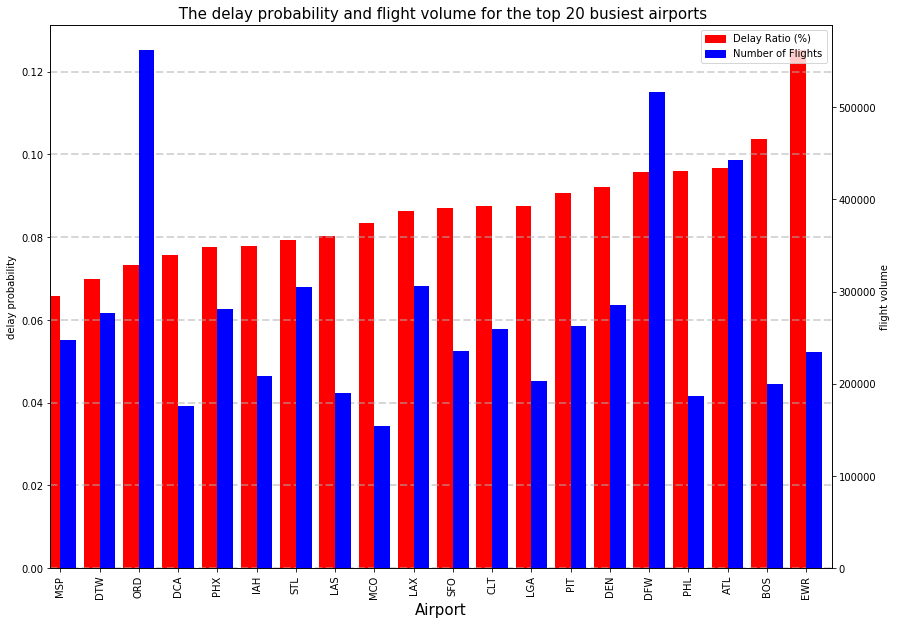

In [79]:
# Converting to Pandas 
Result_Table_pd = pd.DataFrame(data= Result_Table, columns=['Airport', 'Prob','Volume'])

fig = plt.figure(figsize = (14,10)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

Result_Table_pd.Prob.plot(kind='bar', color='red', ax=ax, width=width, position=1, label='Delay probability')
Result_Table_pd.Volume.plot(kind='bar', color='blue', ax=ax2, width=width, position=0,  label='flight volume')

ax.set_xticklabels(Result_Table_pd.Airport)
ax.set_title(" The delay probability and flight volume for the top 20 busiest airports",fontsize=15)
ax.set_xlabel("Airport",fontsize=15)
ax2.set_ylabel('Flight volume')
ax.set_ylabel('Delay probability')

dr_patch = mpatches.Patch(color='r', label='Delay Probability')
nf_patch = mpatches.Patch(color='b', label='Number of Flights')
plt.legend(handles=[dr_patch,nf_patch])

ax.grid(True, axis='y', linestyle='--',alpha = 0.5,linewidth=2)
plt.show()


### Question 4.7

<div class="alert alert-info">
What is the percentage of delayed flights which belong to one of the top 20 busiest carriers?  
Comment the figure!

<ul></ul>
<div class="label label-success">SUGGESTION </div>  You can try with different chart type to have a better visualization.
</div>

In [157]:
Busiest_20_carriers= Busiest_carriers.limit(20)

Busiest_20_carriers.show()



# Number of delayed flight per carrier:
df_Carriers_delay_flights = (
                                df[df.arrival_delay > 15]
                                .groupBy(df.carrier)
                                .count()
                                .orderBy(desc('count'))
                            )


# Total number of delayed flights
total_delayed_flights = (
    df_Carriers_delay_flights
    .agg(func.sum('count').alias('Total'))
     .collect()[0].Total
)

 
                
Result_Table = (
    Busiest_20_carriers
    .join(df_Carriers_delay_flights,df_Carriers_delay_flights.carrier == Busiest_20_carriers.carrier, "inner")
    .select(Busiest_20_carriers.carrier,Busiest_20_carriers['count'], 
            ((df_Carriers_delay_flights["count"]/Busiest_20_carriers['count'])*100).alias('% Carrier Delayed flight'),
            ((df_Carriers_delay_flights["count"]/total_delayed_flights)*100).alias('% Delay per total delay'))
    
)

              
Result_Table.show()






+-------+------+
|carrier| count|
+-------+------+
|     DL|874526|
|     US|857906|
|     AA|722277|
|     UA|638750|
|     WN|565426|
|     CO|484834|
|     NW|482798|
|     TW|258205|
|     HP|177851|
|     AS|117475|
+-------+------+

+-------+------+-------------------+-----------------------+
|carrier| count|% Delay per carrier|% Delay per total delay|
+-------+------+-------------------+-----------------------+
|     US|857906|  17.31425121167121|     17.985990446380463|
|     DL|874526|  16.94415031685736|     17.942520872055358|
|     AA|722277|  16.52966936507739|     14.456357879314416|
|     UA|638750| 15.880704500978474|     12.282636992728836|
|     CO|484834| 18.443632253513574|     10.827556561907818|
|     WN|565426| 12.075850774460319|      8.267695083336864|
|     NW|482798| 12.181284926615271|      7.121139653575343|
|     TW|258205| 17.115470265874013|      5.351116707936527|
|     HP|177851| 17.262202630291647|     3.7174356583703148|
|     AS|117475| 14.394552032

## Additional Interesting Queries

### 1 - Study Flight Distance per Carrier and whether Airlines cover Short-haul, Medium-haul, or Long-haul flights

The goal of the next series of queries is to study the flights' length with respect to each carrier in order to identify the type of flights provided by the airlines present in the 1994 dataset.

In [40]:
# load the carriers csv file from hdfs into a SparkSQL DataFrame
df_carriers = sqlContext.read.load('/user/kandakji/carriers.csv', 
    format='com.databricks.spark.csv', 
    header='true', 
    inferSchema='true',
    nullValue='NA'
)

#### a - Distance Statistics

First, the categorization is done according to the flight distance statistics. According to Wikipedia:<br> Short-Haul flights have a distance below <b> 932.0568 Miles</b><br>Medium-Haul flights have a distance between <b> 932.0568 Miles</b> and <b>2485.485 Miles</b><br> and Long-Haul flights cover a distance larger than <b>2485.485 Miles</b>

In [119]:
# Group the dataframe per carrier and aggregate by averaging the flight distance per carrier

carrier_mean_dist = df.groupBy('carrier')\
.avg('distance')\
.toPandas()

# Group the dataframe per carrier and aggregate by the standard deviation the flight distance per carrier

carrier_stddev_dist = df.groupBy('carrier')\
.agg(stddev_pop('distance'))\
.toPandas()

In [165]:
print('The airlines involved in the flights present in the dataset are the following:\n\n')
df.select('carrier').distinct().join(df_carriers, df.carrier ==  df_carriers.Code, 'inner').select('carrier','Description').show()

The airlines involved in the flights present in the dataset are the following:


+-------+--------------------+
|carrier|         Description|
+-------+--------------------+
|     UA|United Air Lines ...|
|     AA|American Airlines...|
|     NW|Northwest Airline...|
|     HP|America West Airl...|
|     TW|Trans World Airwa...|
|     DL|Delta Air Lines Inc.|
|     US|US Airways Inc. (...|
|     AS|Alaska Airlines Inc.|
|     CO|Continental Air L...|
|     WN|Southwest Airline...|
+-------+--------------------+



/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<BarContainer object of 10 artists>

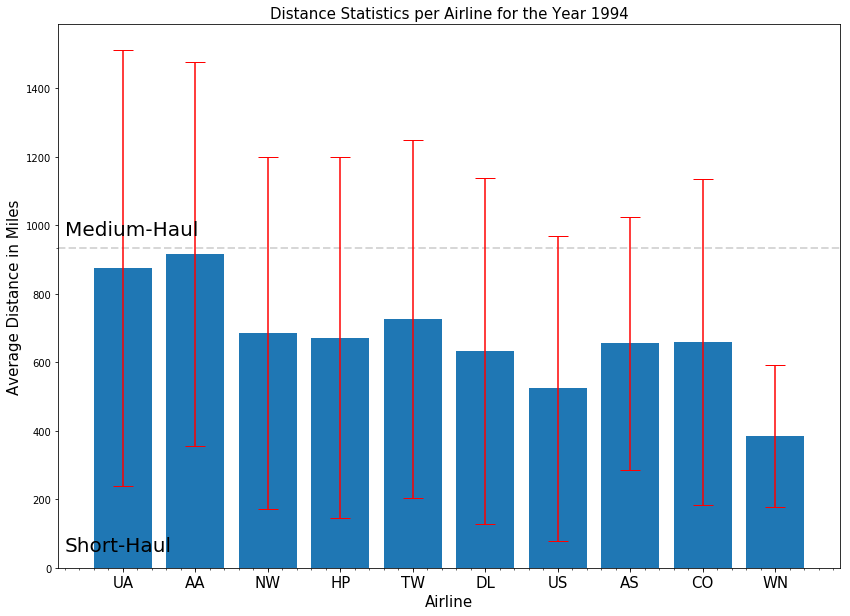

In [163]:
plt.figure(figsize = (14,10))
plt.grid(True, axis='y', linestyle='--',alpha = 0.5,linewidth=2, which = 'minor')
plt.title("Distance Statistics per Airline for the Year 1994",fontsize=15)
plt.xlabel("Airline",fontsize=15)
plt.ylabel("Average Distance in Miles",fontsize=15)
plt.xticks(fontsize = 15)
plt.minorticks_on()
plt.axes().set_yticks(ticks = [932.0568,2485.485], minor = True)
plt.annotate("Short-Haul",(-0.8, 50),fontsize=20)
plt.annotate("Medium-Haul",(-0.8, 970),fontsize=20)
# plt.annotate("Long-Haul",(-0.8, 3000),fontsize=20, rotation = 'vertical')
plt.bar(carrier_mean_dist["carrier"],
        carrier_mean_dist["avg(distance)"],
        yerr = carrier_stddev_dist['stddev_pop(distance)'],
        capsize=10,
        ecolor = 'r'
       )

According to the obtained distance means and standard deviations corresponding to each airline, the airlines are distributed as short-haul or medium-haul airlines.<br>
United Airlines (UA) and American Airlines (AA) provide both a great deal of medium-haul flights as well as short-haul flights. Airlines like US Airways (US), Alaska Airlines (AS), and Southwest Airline (WN) provide mostly short-haul trips. The other Airlines provide both short-haul flights mainly, but also provide medium-haul flight but at a lower rate. However, there are no airlines in the dataset that provide long-haul flights in general.

#### b - Duration Statistics

Secondly, the categorization is done according to the flight duration statistics. According to Wikipedia:<br> Short-Haul flights have a duration below <b> 3 hours</b><br>Medium-Haul flights have a duration between <b> 3 hours</b> and <b>6 hours</b><br> and Long-Haul flights cover a duration longer than <b>6 hours</b>

In [121]:
df1 = sqlContext.createDataFrame(cleaned_data_to_columns, airline_data_schema)\
    .select(['carrier','scheduled_elapsed_time'])\
    .cache()

In [122]:
# Group the dataframe per carrier and aggregate by averaging the flight duration per carrier

carrier_mean_dur = df1.groupBy('carrier')\
.avg('scheduled_elapsed_time')\
.select('carrier',(col('avg(scheduled_elapsed_time)')/60).alias('average_duration'))\
.toPandas()

# Group the dataframe per carrier and aggregate by the standard deviation the flight distance per carrier

carrier_stddev_dur = df1.groupBy('carrier')\
.agg(stddev_pop('scheduled_elapsed_time'))\
.select('carrier',(col('stddev_pop(scheduled_elapsed_time)')/60).alias('stddev_duration'))\
.toPandas()

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<BarContainer object of 10 artists>

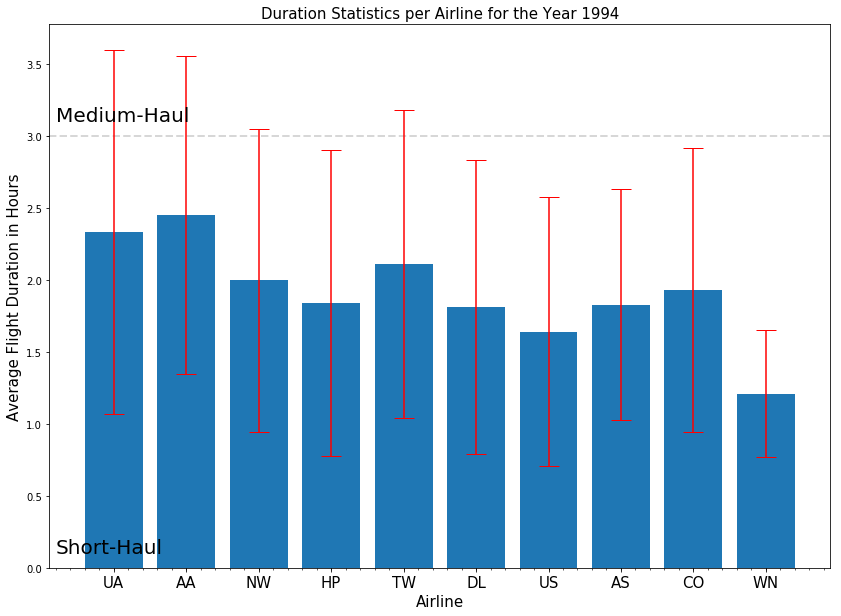

In [147]:
plt.figure(figsize = (14,10))
plt.grid(True, axis='y', linestyle='--',alpha = 0.5,linewidth=2, which = 'minor')
plt.title("Duration Statistics per Airline for the Year 1994",fontsize=15)
plt.xlabel("Airline",fontsize=15)
plt.ylabel("Average Flight Duration in Hours",fontsize=15)
plt.xticks(fontsize = 15)
plt.minorticks_on()
plt.axes().set_yticks(ticks = [3,6], minor = True)
plt.annotate("Short-Haul",(-0.8, 0.1),fontsize=20)
plt.annotate("Medium-Haul",(-0.8, 3.1),fontsize=20)
# plt.annotate("Long-Haul",(-0.8, 3000),fontsize=20, rotation = 'vertical')
plt.bar(carrier_mean_dur["carrier"],
        carrier_mean_dur["average_duration"],
        yerr = carrier_stddev_dur['stddev_duration'],
        capsize=10,
        ecolor = 'r'
       )

According to the obtained duration means and standard deviations corresponding to each airline, all the airlines are mainly operating or providing short-haul flights with some of them providing some medium-haul flights.<br>
In this case, United Airlines (UA) and American Airlines (AA) provide some flights that are up to 3.6 hours in duration (medium-haul) but the flights are short-haul in majority. The other Airlines provide short-haul flights mainly. However, there are no airlines in the dataset that provide long-haul flights in general.

## Addition (bonus) questions

### Additional data
In the HDFS file system you have used for running the Notebook, you will notice that there are several other years available (in addition to 1994).

There are some other datasets that related to this use case:

- Airport IATA Codes to City names and Coordinates mapping: http://stat-computing.org/dataexpo/2009/airports.csv
- Carrier codes to Full name mapping: http://stat-computing.org/dataexpo/2009/carriers.csv
- Information about individual planes: http://stat-computing.org/dataexpo/2009/plane-data.csv
- Weather information: http://www.wunderground.com/weather/api/. You can subscribe for free to the developers' API and obtain (at a limited rate) historical weather information in many different formats. Also, to get an idea of the kind of information is available, you can use this link: http://www.wunderground.com/history/

### Question 5.1

<div class="alert alert-info">

Which airports are present in the dataset only as destination airport?

Which airport is present only as source airport in the dataset? 

</div>

### Question 5.2

<div class="alert alert-info">

Which airports have biggest delay probability ?

Which cities have largest delay duration in average ?

</div>

### Question 5.3

<div class="alert alert-info">

Is there any relationship between weather condition and the delay of flights in 1994 ?

</div>


### Answer 5.1

In [60]:
print("The airports which are present as destination airports only:\n\n")
df.select("dest_airport").join(df.select("src_airport"), df.dest_airport == df.src_airport, how = 'left_anti').drop_duplicates().show()
print("The airports which are present as source airports only:\n\n")
df.select("src_airport").join(df.select("dest_airport"), df.src_airport == df.dest_airport, how = 'left_anti').drop_duplicates().show()

The airports which are present as destination airports only:


+------------+
|dest_airport|
+------------+
|         BFI|
|         GUM|
+------------+

The airports which are present as source airports only:


+-----------+
|src_airport|
+-----------+
|        SPN|
+-----------+



### Answer 5.2

In [131]:
df2 = sqlContext.createDataFrame(cleaned_data_to_columns, airline_data_schema)\
    .select(['arrival_delay', 'departure_delay',
            'src_airport', 'dest_airport'])\
    .cache()

In [132]:
# Number of delayed flights per source airport
df_flights_delay_per_src_airport = df1[df1.departure_delay > 15]\
.groupBy(df1.src_airport)\
.count()

# Number of flights per source airport
df_flights_per_src_airport = df1.groupBy(df1.src_airport)\
.count()


# probability of delayed flights per source airport
print("The source airports that have the highest delay probability are:\n")
df_flights_per_src_airport.join(df_flights_delay_per_src_airport, df_flights_per_src_airport.src_airport == df_flights_delay_per_src_airport.src_airport, 'inner')\
.select(df_flights_per_src_airport.src_airport, (df_flights_delay_per_src_airport['count']/df_flights_per_src_airport['count']).alias('delay_Probability'))\
.orderBy('delay_Probability', ascending = False)\
.show()



The source airports that have the highest delay probability are:

+-----------+-------------------+
|src_airport|  delay_Probability|
+-----------+-------------------+
|        MTJ| 0.2777777777777778|
|        DRO|0.23529411764705882|
|        ACK|0.22727272727272727|
|        PIT|0.19037693640868245|
|        GUC|0.18269230769230768|
|        EWR| 0.1779854069608112|
|        CLT|0.17443253394749247|
|        JFK|0.16348919194730493|
|        DUT|0.15963855421686746|
|        PFN|0.15671062839410396|
|        BOS|0.15191550839436058|
|        EGE|0.15097690941385436|
|        PHL| 0.1491050916279318|
|        BWI|0.14612975265811762|
|        SIT| 0.1431686046511628|
|        DFW|0.14286271724794555|
|        DEN| 0.1413096509153132|
|        GSO| 0.1378406270047137|
|        ADQ|0.13711583924349882|
|        MFR| 0.1359773371104816|
+-----------+-------------------+
only showing top 20 rows



In [136]:
# Number of delayed flights per destination airport
df_flights_delay_per_dest_airport = df1[df1.arrival_delay > 15]\
.groupBy(df1.dest_airport)\
.count()

# Number of flights per destination airport
df_flights_per_dest_airport = df1.groupBy(df1.dest_airport)\
.count()

# probability of delayed flights per destination airport

print("The destination airports that have the highest delay probability are:\n")

df_flights_per_dest_airport.join(df_flights_delay_per_dest_airport, df_flights_per_dest_airport.dest_airport == df_flights_delay_per_dest_airport.dest_airport, 'inner')\
.select(df_flights_per_dest_airport.dest_airport, (df_flights_delay_per_dest_airport['count']/df_flights_per_dest_airport['count']).alias('delay_Probability'))\
.orderBy('delay_Probability', ascending = False).show()


The destination airports that have the highest delay probability are:

+------------+-------------------+
|dest_airport|  delay_Probability|
+------------+-------------------+
|         MTJ|                0.5|
|         SPI|                0.5|
|         ACK|               0.35|
|         GUC| 0.2985781990521327|
|         EGE|0.26798561151079137|
|         BFL|0.26153846153846155|
|         EWR|0.24737466196906752|
|         PBI|0.22718675129250557|
|         HDN| 0.2270168855534709|
|         JFK|0.22661521397541362|
|         BQN|0.22156573116691286|
|         BOS|0.22123002889329615|
|         DAB| 0.2209379862191598|
|         AVP|0.22061191626409019|
|         PFN|0.21821036106750394|
|         GJT|  0.215962441314554|
|         MLB|0.21465968586387435|
|         LFT| 0.2145922746781116|
|         RSW|0.21400051519835137|
|         SAV| 0.2129781217443072|
+------------+-------------------+
only showing top 20 rows



In [115]:
df_cities = sqlContext.read.load('/user/kandakji/airports.csv', 
    format='com.databricks.spark.csv', 
    header='true', 
    inferSchema='true',
    nullValue='NA'
)

In [137]:
# Average delay of flights per source airport
df_flights_per_src_airport = df.groupBy(df.src_airport.alias('iata'))\
                            .avg('arrival_delay')\
                            .join(df_cities,"iata","inner")\
                            .orderBy('avg(arrival_delay)', ascending = 0)\
                            .select('city','avg(arrival_delay)')

print("The cities that have the largest delay duration on average are:\n\n")
df_flights_per_src_airport.show()

The cities that have the largest delay duration on average are:


+-----------------+------------------+
|             city|avg(arrival_delay)|
+-----------------+------------------+
|        Nantucket|              15.9|
|           Newark|11.807407869413359|
|        Aguadilla|11.173722627737225|
|      Panama City|10.543461237274864|
|           Juneau|10.095909342177999|
|      Bakersfield|10.074786324786325|
|         New York| 9.989412965556532|
|            Sitka|  9.56711915535445|
|         Unalaska| 9.528169014084508|
|Dallas-Fort Worth|  9.32878026820831|
|           Kodiak| 9.127604166666666|
|       Petersburg| 8.864820846905538|
|         Wrangell| 8.834670947030498|
|           Bethel| 8.685785536159601|
|       St. Mary's| 8.629032258064516|
|         Gunnison| 8.558823529411764|
|          Yakutat| 8.274596182085169|
|        Charlotte| 8.260802384407231|
|         Kotzebue| 8.195842450765864|
|     Philadelphia| 8.159339634032557|
+-----------------+------------------

### Answer 5.2